# Prophet를 활용한 예측
- https://zzsza.github.io/data/2019/02/06/prophet/
- https://skyeong.net/290
- https://hyperconnect.github.io/2020/03/09/prophet-package.html

In [18]:
import os
import warnings

import pandas as pd
from datetime import datetime

from fbprophet import Prophet
from fbprophet.plot import plot_plotly

import numpy as np
import matplotlib.pyplot as plt

import wandb

pd.set_option('display.max_row', 100)
pd.set_option('display.max_column', 37)
warnings.filterwarnings(action='ignore')

## Load data

In [3]:
DATA_DIR = os.path.abspath(os.path.dirname('EDA.ipynb') + 'data' + '/EDA')

In [4]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train', 'train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_DIR, 'train', 'validate.csv'))

In [5]:
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test', 'test.csv'))
submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))

In [6]:
def convert(date):
    return date[:4] + '-' + date[4:6] + '-' + date[6:]

def date_to_timestamp(df):
    new_df = df.copy()
    
    date_series = new_df['날짜'].astype(str).map(convert)
    time_series = new_df['시간'].astype(str).map(lambda x: ' ' + x.zfill(2) + ':00:00')
    
    new_df['날짜'] = date_series + time_series
    
    new_df['날짜'] = pd.to_datetime(new_df['날짜'])
    new_df.drop(['시간'], axis=1, inplace=True)
    
    return new_df

In [7]:
train = date_to_timestamp(train_df)
train

날짜        10       100      101      120      121  \
0    2020-01-01 00:00:00   83247.0   19128.0   2611.0   5161.0   1588.0   
1    2020-01-01 01:00:00   89309.0   19027.0   3337.0   5502.0   1650.0   
2    2020-01-01 02:00:00   66611.0   14710.0   2970.0   4631.0   1044.0   
3    2020-01-01 03:00:00   53290.0   13753.0   2270.0   4242.0   1021.0   
4    2020-01-01 04:00:00   52095.0   17615.0   2406.0   3689.0   1840.0   
...                  ...       ...       ...      ...      ...      ...   
3307 2020-05-17 19:00:00  311727.0  101285.0  10085.0  30637.0  10060.0   
3308 2020-05-17 20:00:00  305354.0   91426.0   8607.0  26021.0   8095.0   
3309 2020-05-17 21:00:00  306008.0   75113.0   6325.0  19933.0   5711.0   
3310 2020-05-17 22:00:00  237447.0   49498.0   4209.0  12145.0   3891.0   
3311 2020-05-17 23:00:00  150312.0   27410.0   2350.0   6406.0   1803.0   

         140       150     160      200     201      251      270      300  \
0      892.0   32263.0  1636.0   7938.0  1894.0  14957.0   3527.0  11174.0   
1     1043.0   35609.0  1644.0   9896.0  1967.0  14682.0   3420.0  13884.0   
2      921.0   26821.0  1104.0   9343.0  1838.0  11120.0   3587.0  17141.0   
3      790.0   21322.0   909.0  10009.0  1630.0   9836.0   3842.0  20715.0   
4      922.0   22711.0  1354.0  15497.0  1264.0  10668.0   4559.0  28308.0   
...      ...       ...     ...      ...     ...      ...      ...      ...   
3307  8749.0  148935.0  6801.0  26101.0  9370.0  74169.0  17764.0  34715.0   
3308  7198.0  136503.0  6147.0  20759.0  8432.0  68923.0  14593.0  30279.0   
3309  4494.0  129412.0  5134.0  14496.0  6739.0  54455.0  11997.0  27047.0   
3310  2718.0   96698.0  3526.0   9363.0  4543.0  35618.0   7996.0  19478.0   
3311  1614.0   55788.0  1849.0   5722.0  2611.0  21993.0   4567.0  12547.0   

          301      351      352      370      400      450      500      550  \
0      2930.0   8640.0  14175.0   2035.0   5231.0  18492.0  48520.0  15393.0   
1      3062.0   8349.0  15654.0   2417.0   5483.0  15283.0  57904.0  15834.0   
2      3255.0   7025.0  12520.0   1859.0   5058.0  14327.0  53876.0  13866.0   
3      2661.0   7226.0   9821.0   1724.0   4863.0  12787.0  51615.0  13528.0   
4      2894.0   8201.0   9038.0    960.0   5166.0  11479.0  47424.0  18156.0   
...       ...      ...      ...      ...      ...      ...      ...      ...   
3307  19806.0  42734.0  63382.0  14130.0  34866.0  71475.0  96849.0  79150.0   
3308  17634.0  37661.0  57815.0  13055.0  31943.0  65378.0  92116.0  72379.0   
3309  15943.0  29029.0  54627.0  12292.0  27424.0  60696.0  83628.0  57866.0   
3310  10010.0  18663.0  39694.0   8818.0  17770.0  45983.0  57321.0  35250.0   
3311   5756.0  10595.0  21670.0   5379.0  10185.0  31934.0  33200.0  19428.0   

          600      650      652      1000    1020     1040     1100     1200  \
0     16628.0   8804.0   2790.0   38657.0  1311.0   3482.0  11299.0   7072.0   
1     19785.0   8483.0   3381.0   45759.0  1162.0   3849.0  13180.0   8771.0   
2     24501.0   8167.0   2670.0   27425.0   768.0   2299.0   7986.0   5426.0   
3     28695.0   9459.0   2325.0   18893.0   632.0   1716.0   5703.0   3156.0   
4     26977.0  10944.0   3583.0   18135.0   875.0   2421.0   5816.0   2933.0   
...       ...      ...      ...       ...     ...      ...      ...      ...   
3307  25109.0  14680.0  10465.0  128344.0  6726.0  15431.0  25597.0  14292.0   
3308  23165.0  11879.0   9135.0  131682.0  5501.0  15378.0  24661.0  14747.0   
3309  16629.0   8573.0   6488.0  127826.0  4216.0  12558.0  22781.0  14081.0   
3310  10761.0   5331.0   4109.0   94288.0  2578.0   8870.0  16640.0  11066.0   
3311   5395.0   3256.0   2499.0   52917.0  1377.0   5021.0  10058.0   7139.0   

        1510     2510    3000     4510     5510     6000  
0     1176.0   3810.0   748.0   3920.0   2133.0   3799.0  
1     1283.0   3763.0   782.0   3483.0   2057.0   4010.0  
2     1536.0   3229.0   491.0   2634.0   1526.0   3388.0  
3     1104.0   2882.0   43

In [8]:
valid = date_to_timestamp(valid_df)
valid[168:]

날짜      10      100      101      120     121     140  \
168 2020-05-18 00:00:00   82065  15172.0   1500.0   3294.0  1086.0   962.0   
169 2020-05-18 01:00:00   51248   9840.0    813.0   2356.0   696.0   546.0   
170 2020-05-18 02:00:00   39026   7894.0    760.0   2413.0   408.0   549.0   
171 2020-05-18 03:00:00   40993  10137.0    780.0   2701.0   420.0   741.0   
172 2020-05-18 04:00:00   77863  19603.0   1276.0   5019.0   968.0  1160.0   
..                  ...     ...      ...      ...      ...     ...     ...   
331 2020-05-24 19:00:00  314226  98345.0  10625.0  28618.0  8316.0  6684.0   
332 2020-05-24 20:00:00  300001  87871.0   8226.0  22706.0  6981.0  5743.0   
333 2020-05-24 21:00:00  304150  71126.0   6002.0  18317.0  4939.0  3779.0   
334 2020-05-24 22:00:00  236751  44947.0   3575.0  11455.0  3135.0  2536.0   
335 2020-05-24 23:00:00  143609  26137.0   2242.0   6166.0  1609.0  1391.0   

        150     160    200     201      251      270      300      301  \
168   28931  1103.0   3014  1619.0  12596.0   3060.0   7383.0   2958.0   
169   17888   720.0   1839  1502.0   7741.0   2132.0   4790.0   1743.0   
170   13357   498.0   1360  1233.0   6475.0   2098.0   3965.0   1345.0   
171   15544   532.0   1671  1800.0   7720.0   2133.0   4083.0   1501.0   
172   32101   968.0   2574  2384.0  12018.0   3502.0   6430.0   2882.0   
..      ...     ...    ...     ...      ...      ...      ...      ...   
331  141675  6619.0  23535  8572.0  67748.0  16791.0  33325.0  19124.0   
332  142933  6295.0  20953  7851.0  61609.0  14119.0  30216.0  18610.0   
333  133110  4781.0  15242  6101.0  48336.0  11534.0  25710.0  15651.0   
334   98582  3267.0   8849  4553.0  33607.0   8069.0  18293.0   9723.0   
335   54633  1899.0   5182  2422.0  20343.0   5104.0  11331.0   5413.0   

         351      352      370    400      450     500      550    600  \
168   5829.0  11297.0   2890.0   5694  19553.0   18919   9907.0   2912   
169   4296.0   6781.0   1752.0   3651  12454.0   11849   6292.0   1750   
170   3957.0   4762.0   1250.0   3199   9640.0    9392   4961.0   1104   
171   3992.0   6202.0   1505.0   4459  10802.0   11664   6015.0   1132   
172   5957.0  11987.0   3176.0   9054  16490.0   23479  10676.0   1945   
..       ...      ...      ...    ...      ...     ...      ...    ...   
331  42183.0  63229.0  13163.0  35383  73188.0  100849  84286.0  26458   
332  35556.0  59070.0  12788.0  30675  68255.0   95107  76441.0  24140   
333  27467.0  53787.0  12019.0  26317  61169.0   86434  61136.0  21076   
334  16602.0  38615.0   8703.0  17694  47609.0   58492  37501.0  12090   
335   9455.0  22150.0   5370.0  10032  31124.0   34013  20205.0   6104   

         650    652      1000    1020     1040     1100   1200    1510   2510  \
168   1884.0   1112   28189.0   618.0   2790.0   5147.0   4331  1329.0   3665   
169   1118.0    703   16683.0   430.0   1864.0   3269.0   2561   921.0   2081   
170   1004.0    485   11934.0   322.0   1313.0   2765.0   1931   920.0   1764   
171   1061.0    851   13458.0   326.0   1766.0   3320.0   2060   892.0   2447   
172   1520.0   1420   31698.0   669.0   2914.0   6986.0   3911  1368.0   4380   
..       ...    ...       ...     ...      ...      ...    ...     ...    ...   
331  15572.0  10341  139827.0  8254.0  16118.0  23304.0  14082  8447.0  21694   
332  13340.0   8872  142469.0  5225.0  15297.0  21919.0  14526  7332.0  19732   
333   9317.0   6392  138816.0  4072.0  12685.0  21135.0  14403  5443.0  16967   
334   5901.0   3938  100767.0  2489.0   8093.0  14427.0  10914  3861.0  11397   
335   3782.0   2272   55574.0  1343.0   4686.0   8732.0   6986  2161.0   6487   

       3000     4510     5510   6000  
168   404.0   2242.0   1619.0   2314  
169   272.0   1390.0   1003.0   1766  
170   228.0   1136.0    922.0   1309  
171   337.0   1495.0    975.0   1912  
172   513.0   2940.0   1758.0   3629  
..      ...      ...      ...    ...  
331  2180.0  15746.0  10903.0  21014  
332  1990.0  14096.0 

In [9]:
test = date_to_timestamp(test_df)
test.head()

날짜     10    100     101   120     121     140    150  \
0 2020-05-18 00:00:00  82065  15172  1500.0  3294  1086.0   962.0  28931   
1 2020-05-18 01:00:00  51248   9840   813.0  2356   696.0   546.0  17888   
2 2020-05-18 02:00:00  39026   7894   760.0  2413   408.0   549.0  13357   
3 2020-05-18 03:00:00  40993  10137   780.0  2701   420.0   741.0  15544   
4 2020-05-18 04:00:00  77863  19603  1276.0  5019   968.0  1160.0  32101   

    160   200   201    251   270   300   301   351    352   370   400    450  \
0  1103  3014  1619  12596  3060  7383  2958  5829  11297  2890  5694  19553   
1   720  1839  1502   7741  2132  4790  1743  4296   6781  1752  3651  12454   
2   498  1360  1233   6475  2098  3965  1345  3957   4762  1250  3199   9640   
3   532  1671  1800   7720  2133  4083  1501  3992   6202  1505  4459  10802   
4   968  2574  2384  12018  3502  6430  2882  5957  11987  3176  9054  16490   

     500    550   600   650   652   1000  1020  1040  1100  1200  1510  2510  \
0  18919   9907  2912  1884  1112  28189   618  2790  5147  4331  1329  3665   
1  11849   6292  1750  1118   703  16683   430  1864  3269  2561   921  2081   
2   9392   4961  1104  1004   485  11934   322  1313  2765  1931   920  1764   
3  11664   6015  1132  1061   851  13458   326  1766  3320  2060   892  2447   
4  23479  10676  1945  1520  1420  31698   669  2914  6986  3911  1368  4380   

   3000  4510  5510  6000  
0   404  2242  1619  2314  
1   272  1390  1003  1766  
2   228  1136   922  1309  
3   337  1495   975  1912  
4   513  2940  1758  3629

In [10]:
submission

timestamp   10  100  101  120  121  140  150  160  200  201  251  270  \
0     20200525_0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     20200525_1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     20200525_2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     20200525_3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     20200525_4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..           ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
163  20200531_19  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
164  20200531_20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
165  20200531_21  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
166  20200531_22  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
167  20200531_23  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

     300  301  351  352  370  400  450  500  550  600  650  652  1000  1020  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   
163  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   
164  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   
165  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   
166  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   
167  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   

     1040  1100  1200  1510  2510  3000  4510  5510  6000  
0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...  
163   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
164   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
165   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
166   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
167   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[168 rows x 36 columns]

In [11]:
# train + valid
new_train = pd.concat([train, valid[168:]])
new_train

날짜        10      100      101      120     121     140  \
0   2020-01-01 00:00:00   83247.0  19128.0   2611.0   5161.0  1588.0   892.0   
1   2020-01-01 01:00:00   89309.0  19027.0   3337.0   5502.0  1650.0  1043.0   
2   2020-01-01 02:00:00   66611.0  14710.0   2970.0   4631.0  1044.0   921.0   
3   2020-01-01 03:00:00   53290.0  13753.0   2270.0   4242.0  1021.0   790.0   
4   2020-01-01 04:00:00   52095.0  17615.0   2406.0   3689.0  1840.0   922.0   
..                  ...       ...      ...      ...      ...     ...     ...   
331 2020-05-24 19:00:00  314226.0  98345.0  10625.0  28618.0  8316.0  6684.0   
332 2020-05-24 20:00:00  300001.0  87871.0   8226.0  22706.0  6981.0  5743.0   
333 2020-05-24 21:00:00  304150.0  71126.0   6002.0  18317.0  4939.0  3779.0   
334 2020-05-24 22:00:00  236751.0  44947.0   3575.0  11455.0  3135.0  2536.0   
335 2020-05-24 23:00:00  143609.0  26137.0   2242.0   6166.0  1609.0  1391.0   

          150     160      200     201      251      270      300      301  \
0     32263.0  1636.0   7938.0  1894.0  14957.0   3527.0  11174.0   2930.0   
1     35609.0  1644.0   9896.0  1967.0  14682.0   3420.0  13884.0   3062.0   
2     26821.0  1104.0   9343.0  1838.0  11120.0   3587.0  17141.0   3255.0   
3     21322.0   909.0  10009.0  1630.0   9836.0   3842.0  20715.0   2661.0   
4     22711.0  1354.0  15497.0  1264.0  10668.0   4559.0  28308.0   2894.0   
..        ...     ...      ...     ...      ...      ...      ...      ...   
331  141675.0  6619.0  23535.0  8572.0  67748.0  16791.0  33325.0  19124.0   
332  142933.0  6295.0  20953.0  7851.0  61609.0  14119.0  30216.0  18610.0   
333  133110.0  4781.0  15242.0  6101.0  48336.0  11534.0  25710.0  15651.0   
334   98582.0  3267.0   8849.0  4553.0  33607.0   8069.0  18293.0   9723.0   
335   54633.0  1899.0   5182.0  2422.0  20343.0   5104.0  11331.0   5413.0   

         351      352      370      400      450       500      550      600  \
0     8640.0  14175.0   2035.0   5231.0  18492.0   48520.0  15393.0  16628.0   
1     8349.0  15654.0   2417.0   5483.0  15283.0   57904.0  15834.0  19785.0   
2     7025.0  12520.0   1859.0   5058.0  14327.0   53876.0  13866.0  24501.0   
3     7226.0   9821.0   1724.0   4863.0  12787.0   51615.0  13528.0  28695.0   
4     8201.0   9038.0    960.0   5166.0  11479.0   47424.0  18156.0  26977.0   
..       ...      ...      ...      ...      ...       ...      ...      ...   
331  42183.0  63229.0  13163.0  35383.0  73188.0  100849.0  84286.0  26458.0   
332  35556.0  59070.0  12788.0  30675.0  68255.0   95107.0  76441.0  24140.0   
333  27467.0  53787.0  12019.0  26317.0  61169.0   86434.0  61136.0  21076.0   
334  16602.0  38615.0   8703.0  17694.0  47609.0   58492.0  37501.0  12090.0   
335   9455.0  22150.0   5370.0  10032.0  31124.0   34013.0  20205.0   6104.0   

         650      652      1000    1020     1040     1100     1200    1510  \
0     8804.0   2790.0   38657.0  1311.0   3482.0  11299.0   7072.0  1176.0   
1     8483.0   3381.0   45759.0  1162.0   3849.0  13180.0   8771.0  1283.0   
2     8167.0   2670.0   27425.0   768.0   2299.0   7986.0   5426.0  1536.0   
3     9459.0   2325.0   18893.0   632.0   1716.0   5703.0   3156.0  1104.0   
4    10944.0   3583.0   18135.0   875.0   2421.0   5816.0   2933.0  1206.0   
..       ...      ...       ...     ...      ...      ...      ...     ...   
331  15572.0  10341.0  139827.0  8254.0  16118.0  23304.0  14082.0  8447.0   
332  13340.0   8872.0  142469.0  5225.0  15297.0  21919.0  14526.0  7332.0   
333   9317.0   6392.0  138816.0  4072.0  12685.0  21135.0  14403.0  5443.0   
334   5901.0   3938.0  100767.0  2489.0   8093.0  14427.0  10914.0  3861.0   
335   3782.0   2272.0   55574.0  1343.0   4686.0   8732.0   6986.0  2161.0   

        2510    3000     4510     5510     6000  
0     3810.0   748.0   3920.0   2133.0   3799.0  
1     3763.0   782.0   3483.0   2057.0   4010.0  
2     3229.0   491.0   2634.0   1526.0   3388.0  
3     2882.0   431.0   24

## 결측값 데이터 처리
- 3월 30일 데이터 00, 01시 데이터만 존재 -> 나머지 데이터 전, 후 1주의(같은 요일) 시간대의 평균으로 삽입

## EDA

In [17]:
new_train.describe()

10            100           101            120  \
count    3480.000000    3480.000000   3480.000000    3480.000000   
mean   232312.158549   67069.203424   7179.008214   17448.708357   
std    121527.292760   41698.694498   5553.702670   13289.193388   
min     18729.000000    3927.000000    313.000000     937.000000   
25%    112707.750000   23936.000000   1915.750000    5243.500000   
50%    268308.000000   74793.500000   7014.000000   16711.500000   
75%    327515.750000  100138.250000  10922.250000   26102.000000   
max    580098.000000  200808.000000  45869.000000  114833.000000   

                121           140            150           160           200  \
count   3480.000000   3480.000000    3480.000000   3480.000000   3480.000000   
mean    6667.643151   4709.277035   99679.353376   4410.560896  11469.720690   
std     4787.671474   3528.542297   58276.054704   2852.798203   8727.435362   
min      229.000000    197.000000    7095.000000    222.000000     55.000000   
25%     1719.750000   1334.250000   43717.500000   1542.000000   3258.500000   
50%     7058.000000   4752.000000  112252.000000   4780.000000  10888.500000   
75%    10338.000000   6970.750000  140990.250000   6671.000000  16591.000000   
max    24596.000000  24639.000000  292004.000000  14163.000000  48349.000000   

                201            251           270           300           301  \
count   3480.000000    3480.000000   3480.000000   3480.000000   3480.000000   
mean    6277.506130   47662.272390  12458.200239  19879.393989  12318.978472   
std     4219.738868   30071.555807   8652.375984  13848.494891   9116.462433   
min      300.000000    3129.000000    763.000000   1176.000000    491.000000   
25%     2366.500000   16853.250000   4620.250000   7829.750000   3580.750000   
50%     5956.000000   52288.000000  11668.000000  18327.000000  12422.000000   
75%     9363.750000   70074.500000  18241.250000  28601.000000  18230.500000   
max    33416.000000  165038.000000  56939.000000  99035.000000  53279.000000   

                351            352           370           400            450  \
count    3480.00000    3480.000000   3480.000000   3480.000000    3480.000000   
mean    26088.54830   43462.864775   8131.194205  22746.048779   48083.716715   
std     19357.96109   26523.669770   4904.095949  14517.164723   25885.272348   
min      1484.00000    2415.000000    388.000000   1194.000000    3108.000000   
25%      8541.25000   16153.250000   3130.500000   7894.000000   25140.250000   
50%     25241.00000   49343.000000   8799.000000  24395.500000   49247.500000   
75%     37308.00000   64947.000000  12274.250000  34674.250000   67666.500000   
max    131904.00000  118109.000000  19309.000000  74691.000000  153141.000000   

                 500            550           600           650           652  \
count    3480.000000    3480.000000   3480.000000   3480.000000   3480.000000   
mean    76539.925503   49667.645450  14048.058693  11123.793343   6534.256681   
std     43604.441708   36953.598456  12909.321749   9459.559078   4836.203366   
min      4805.000000    2026.000000    530.000000    492.000000    289.000000   
25%     33056.750000   14094.000000   2983.000000   2537.250000   1801.500000   
50%     88092.500000   50325.500000  10554.500000   9790.000000   6703.000000   
75%    109351.500000   74323.250000  20319.500000  16644.500000   9979.000000   
max    215521.000000  239389.000000  67751.000000  58262.000000  37465.000000   

                1000          1020          1040          1100          1200  \
count    3480.000000   3480.000000   3480.000000   3480.000000   3480.000000   
mean   110901.966284   5173.171504  10988.668343  27103.670809  13980.270905   
std     59104.461484   3878.421033   6181.655183  15485.848212   7108.179496   
min      6331.000000    149.000000    746.000000   1220.000000   1040.000000   
25%     51691.500000   1327.750000   4596.500000  11631.000000   7368.000000   
50%    133000.375000   

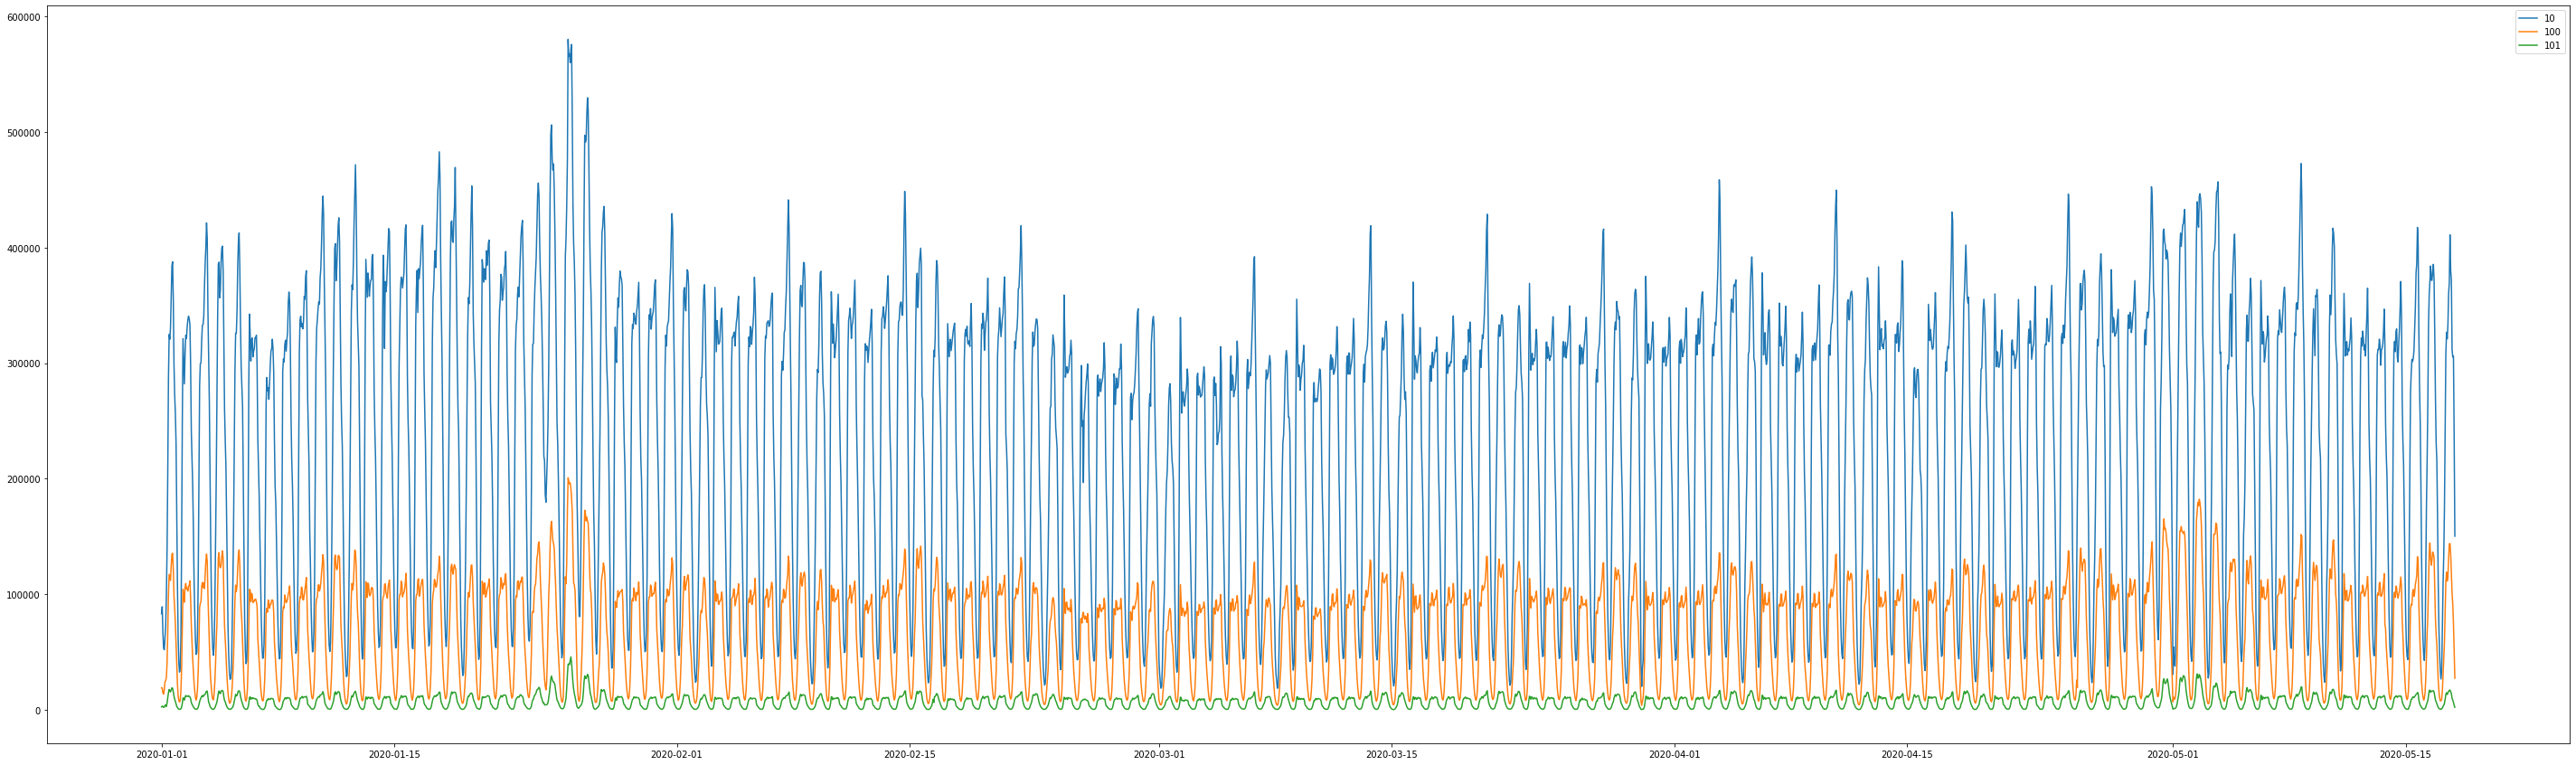

In [18]:
train.columns
plt.figure(figsize=(50, 15))

for col in ['10', '100', '101']:
    plt.plot(train['날짜'], train[col], label=col)
    plt.legend()


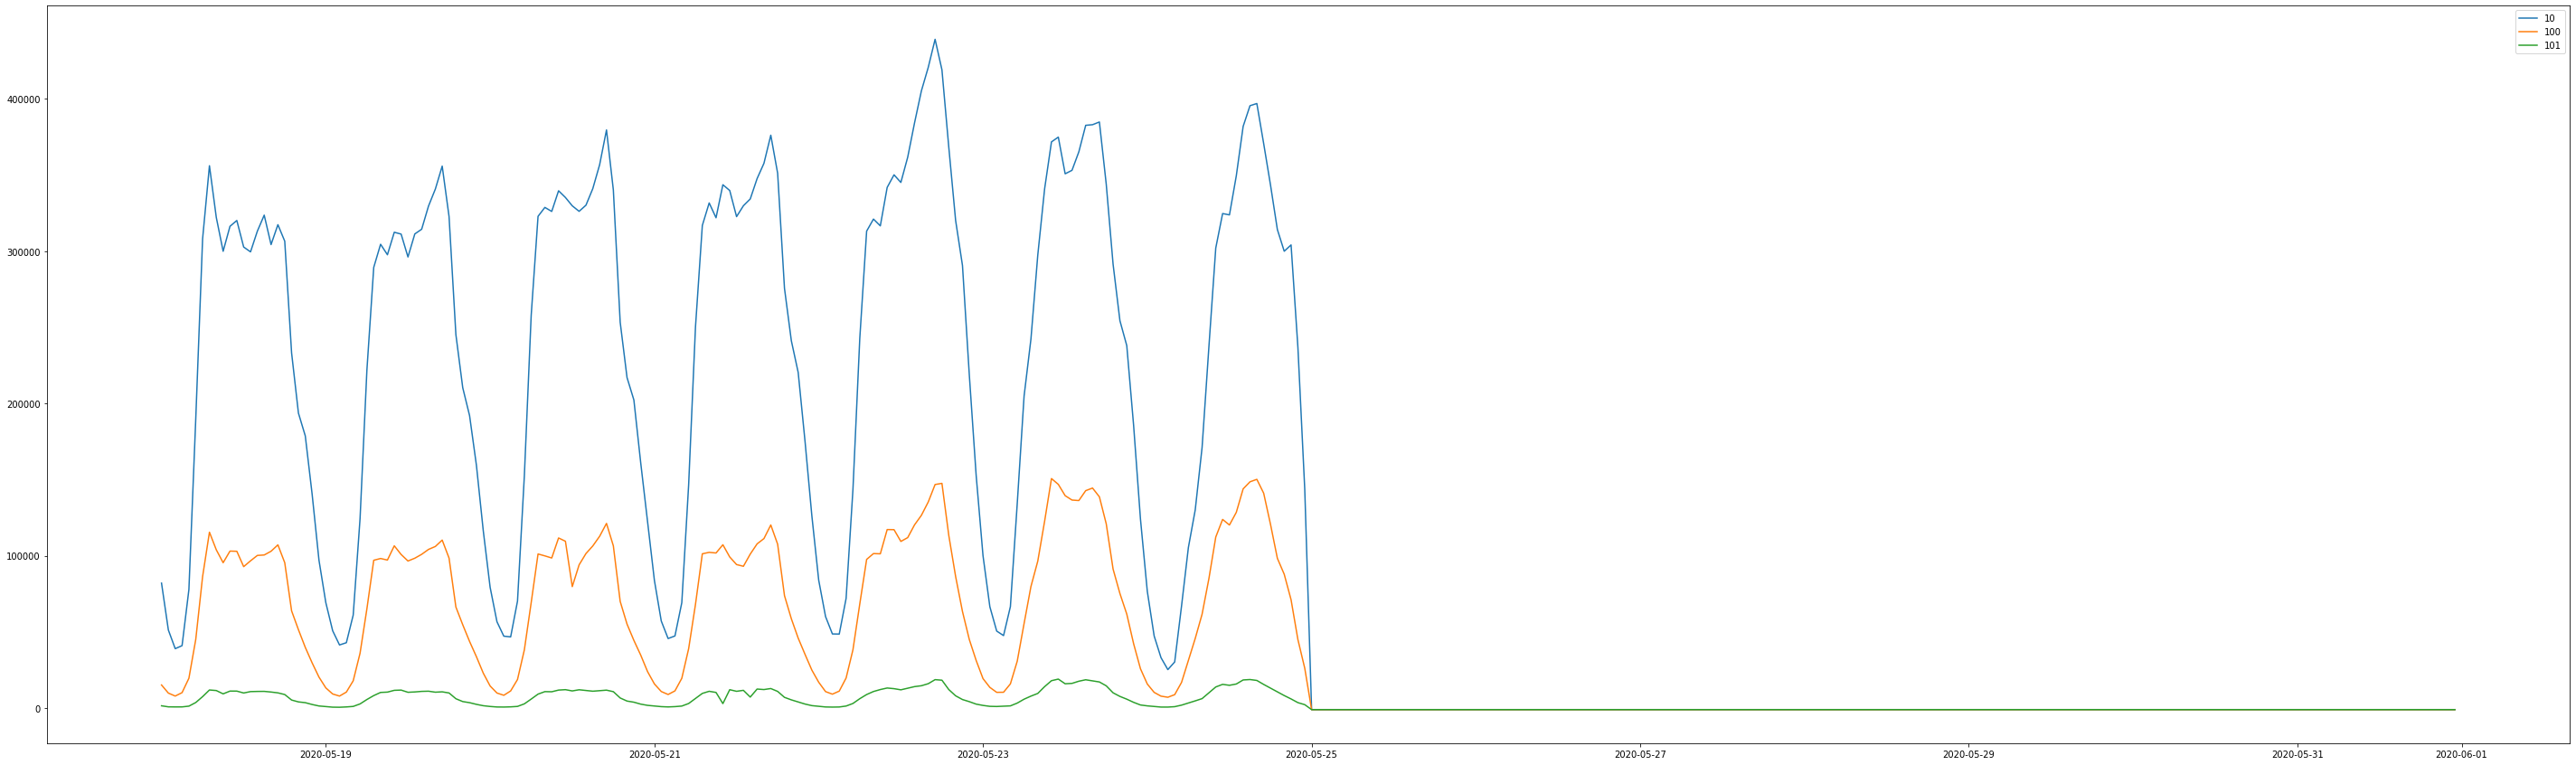

In [19]:
plt.figure(figsize=(50, 15))

for col in ['10', '100', '101']:
    plt.plot(test['날짜'], test[col], label=col)
    plt.legend()

# prophet
## 데이터 생성
- 01.01 ~ 05.24

In [14]:
new_train = pd.concat([train, valid[168:]])
new_train.tail()

날짜        10      100      101      120     121     140  \
331 2020-05-24 19:00:00  314226.0  98345.0  10625.0  28618.0  8316.0  6684.0   
332 2020-05-24 20:00:00  300001.0  87871.0   8226.0  22706.0  6981.0  5743.0   
333 2020-05-24 21:00:00  304150.0  71126.0   6002.0  18317.0  4939.0  3779.0   
334 2020-05-24 22:00:00  236751.0  44947.0   3575.0  11455.0  3135.0  2536.0   
335 2020-05-24 23:00:00  143609.0  26137.0   2242.0   6166.0  1609.0  1391.0   

          150     160      200     201      251      270      300      301  \
331  141675.0  6619.0  23535.0  8572.0  67748.0  16791.0  33325.0  19124.0   
332  142933.0  6295.0  20953.0  7851.0  61609.0  14119.0  30216.0  18610.0   
333  133110.0  4781.0  15242.0  6101.0  48336.0  11534.0  25710.0  15651.0   
334   98582.0  3267.0   8849.0  4553.0  33607.0   8069.0  18293.0   9723.0   
335   54633.0  1899.0   5182.0  2422.0  20343.0   5104.0  11331.0   5413.0   

         351      352      370      400      450       500      550      600  \
331  42183.0  63229.0  13163.0  35383.0  73188.0  100849.0  84286.0  26458.0   
332  35556.0  59070.0  12788.0  30675.0  68255.0   95107.0  76441.0  24140.0   
333  27467.0  53787.0  12019.0  26317.0  61169.0   86434.0  61136.0  21076.0   
334  16602.0  38615.0   8703.0  17694.0  47609.0   58492.0  37501.0  12090.0   
335   9455.0  22150.0   5370.0  10032.0  31124.0   34013.0  20205.0   6104.0   

         650      652      1000    1020     1040     1100     1200    1510  \
331  15572.0  10341.0  139827.0  8254.0  16118.0  23304.0  14082.0  8447.0   
332  13340.0   8872.0  142469.0  5225.0  15297.0  21919.0  14526.0  7332.0   
333   9317.0   6392.0  138816.0  4072.0  12685.0  21135.0  14403.0  5443.0   
334   5901.0   3938.0  100767.0  2489.0   8093.0  14427.0  10914.0  3861.0   
335   3782.0   2272.0   55574.0  1343.0   4686.0   8732.0   6986.0  2161.0   

        2510    3000     4510     5510     6000  
331  21694.0  2180.0  15746.0  10903.0  21014.0  
332  19732.0  1990.0  14096.0  10028.0  17787.0  
333  16967.0  1359.0  11670.0   7963.0  14041.0  
334  11397.0   859.0   7270.0   5194.0   8230.0  
335   6487.0   410.0   3963.0   2686.0   4690.0

## prophet 시각화
- 10번도로로 start

prophet는 데이터를 'ds', 'y'의 데이터프레임을 갖도록 가공해주어야 함.

In [21]:
road = '10'

new_df = pd.DataFrame({
    'ds':new_train['날짜'],
    'y':new_train[road]
})

In [22]:
# Prophet 객체 선언
m = Prophet()

# model 학습
m.fit(new_df)

# 예측값 설정
future = m.make_future_dataframe(periods=168, freq='H')

# 상한선, 하한선 설정
future['cap'] = 500000
future['floor'] = 50000

# predict
forecast = m.predict(future)

print('forecast : ', forecast.columns)

# forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']]
forecast

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -153.355
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7621.05    0.00819247       203.508      0.8004      0.8004      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7634.68    0.00168535       276.623      0.5971      0.5971      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       7637.25   0.000109627       128.356   5.081e-07       0.001      319  LS failed, Hessian reset 
     299       7641.52    5.4436e-05        128.35      0.1961      0.1961      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7642.95    0.00330674       127.517           1           1      527   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     466       7644.21   0.000172479    

ds          trend     cap     yhat_lower     yhat_upper  \
0    2020-01-01 00:00:00  218003.909781  500000   11515.382259  113132.712954   
1    2020-01-01 01:00:00  218123.717785  500000  -16462.786677   78564.200247   
2    2020-01-01 02:00:00  218243.525788  500000  -37636.191825   61213.814144   
3    2020-01-01 03:00:00  218363.333792  500000  -29264.558428   66362.896752   
4    2020-01-01 04:00:00  218483.141796  500000      61.036041   98864.515774   
...                  ...            ...     ...            ...            ...   
3643 2020-05-31 19:00:00  239740.537979  500000  245169.658188  345750.309449   
3644 2020-05-31 20:00:00  239737.705909  500000  212053.535348  305079.694892   
3645 2020-05-31 21:00:00  239734.873838  500000  161542.092982  264385.829717   
3646 2020-05-31 22:00:00  239732.041768  500000  126568.767875  228274.096598   
3647 2020-05-31 23:00:00  239729.209698  500000   91239.466410  191972.709787   

        trend_lower    trend_upper  additive_terms  additive_terms_lower  \
0     218003.909781  218003.909781  -151838.702350        -151838.702350   
1     218123.717785  218123.717785  -185724.863406        -185724.863406   
2     218243.525788  218243.525788  -205953.427218        -205953.427218   
3     218363.333792  218363.333792  -201197.895999        -201197.895999   
4     218483.141796  218483.141796  -166721.899912        -166721.899912   
...             ...            ...             ...                   ...   
3643  237108.097402  242224.869209    58476.748478          58476.748478   
3644  237037.389833  242238.745292    15984.514259          15984.514259   
3645  236983.012456  242258.678649   -25156.659478         -25156.659478   
3646  236933.899357  242279.450265   -62676.777976         -62676.777976   
3647  236896.086529  242302.802721   -98850.188512         -98850.188512   

      additive_terms_upper          daily    daily_lower    daily_upper  \
0           -151838.702350 -141665.148791 -141665.148791 -141665.148791   
1           -185724.863406 -176676.975815 -176676.975815 -176676.975815   
2           -205953.427218 -198046.412359 -198046.412359 -198046.412359   
3           -201197.895999 -194430.642195 -194430.642195 -194430.642195   
4           -166721.899912 -161077.351314 -161077.351314 -161077.351314   
...                    ...            ...            ...            ...   
3643          58476.748478   61993.999069   61993.999069   61993.999069   
3644          15984.514259   17408.672441   17408.672441   17408.672441   
3645         -25156.659478  -25762.694870  -25762.694870  -25762.694870   
3646         -62676.777976  -65227.866699  -65227.866699  -65227.866699   
3647         -98850.188512 -103240.189939 -103240.189939 -103240.189939   

            weekly  weekly_lower  weekly_upper  multiplicative_terms  \
0    -10173.553559 -10173.553559 -10173.553559                   0.0   
1     -9047.887592  -9047.887592  -9047.887592                   0.0   
2     -7907.014859  -7907.014859  -7907.014859                   0.0   
3     -6767.253803  -6767.253803  -6767.253803                   0.0   
4     -5644.548599  -5644.548599  -5644.548599                   0.0   
...            ...           ...           ...                   ...   
3643  -3517.250591  -3517.250591  -3517.250591                   0.0   
3644  -1424.158182  -1424.158182  -1424.158182                   0.0   
3645    606.035392    606.035392    606.035392                   0.0   
3646   2551.088723   2551.088723   2551.088723                   0.0   
3647   4390.001427   4390.001427   4390.001427                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper           yhat  
0                            0.0                         0.0   66165.207431  
1                            0.0                         0.0   32398.854378  
2                            0.0                         0.0   12290.098570  
3                            0.0                         0

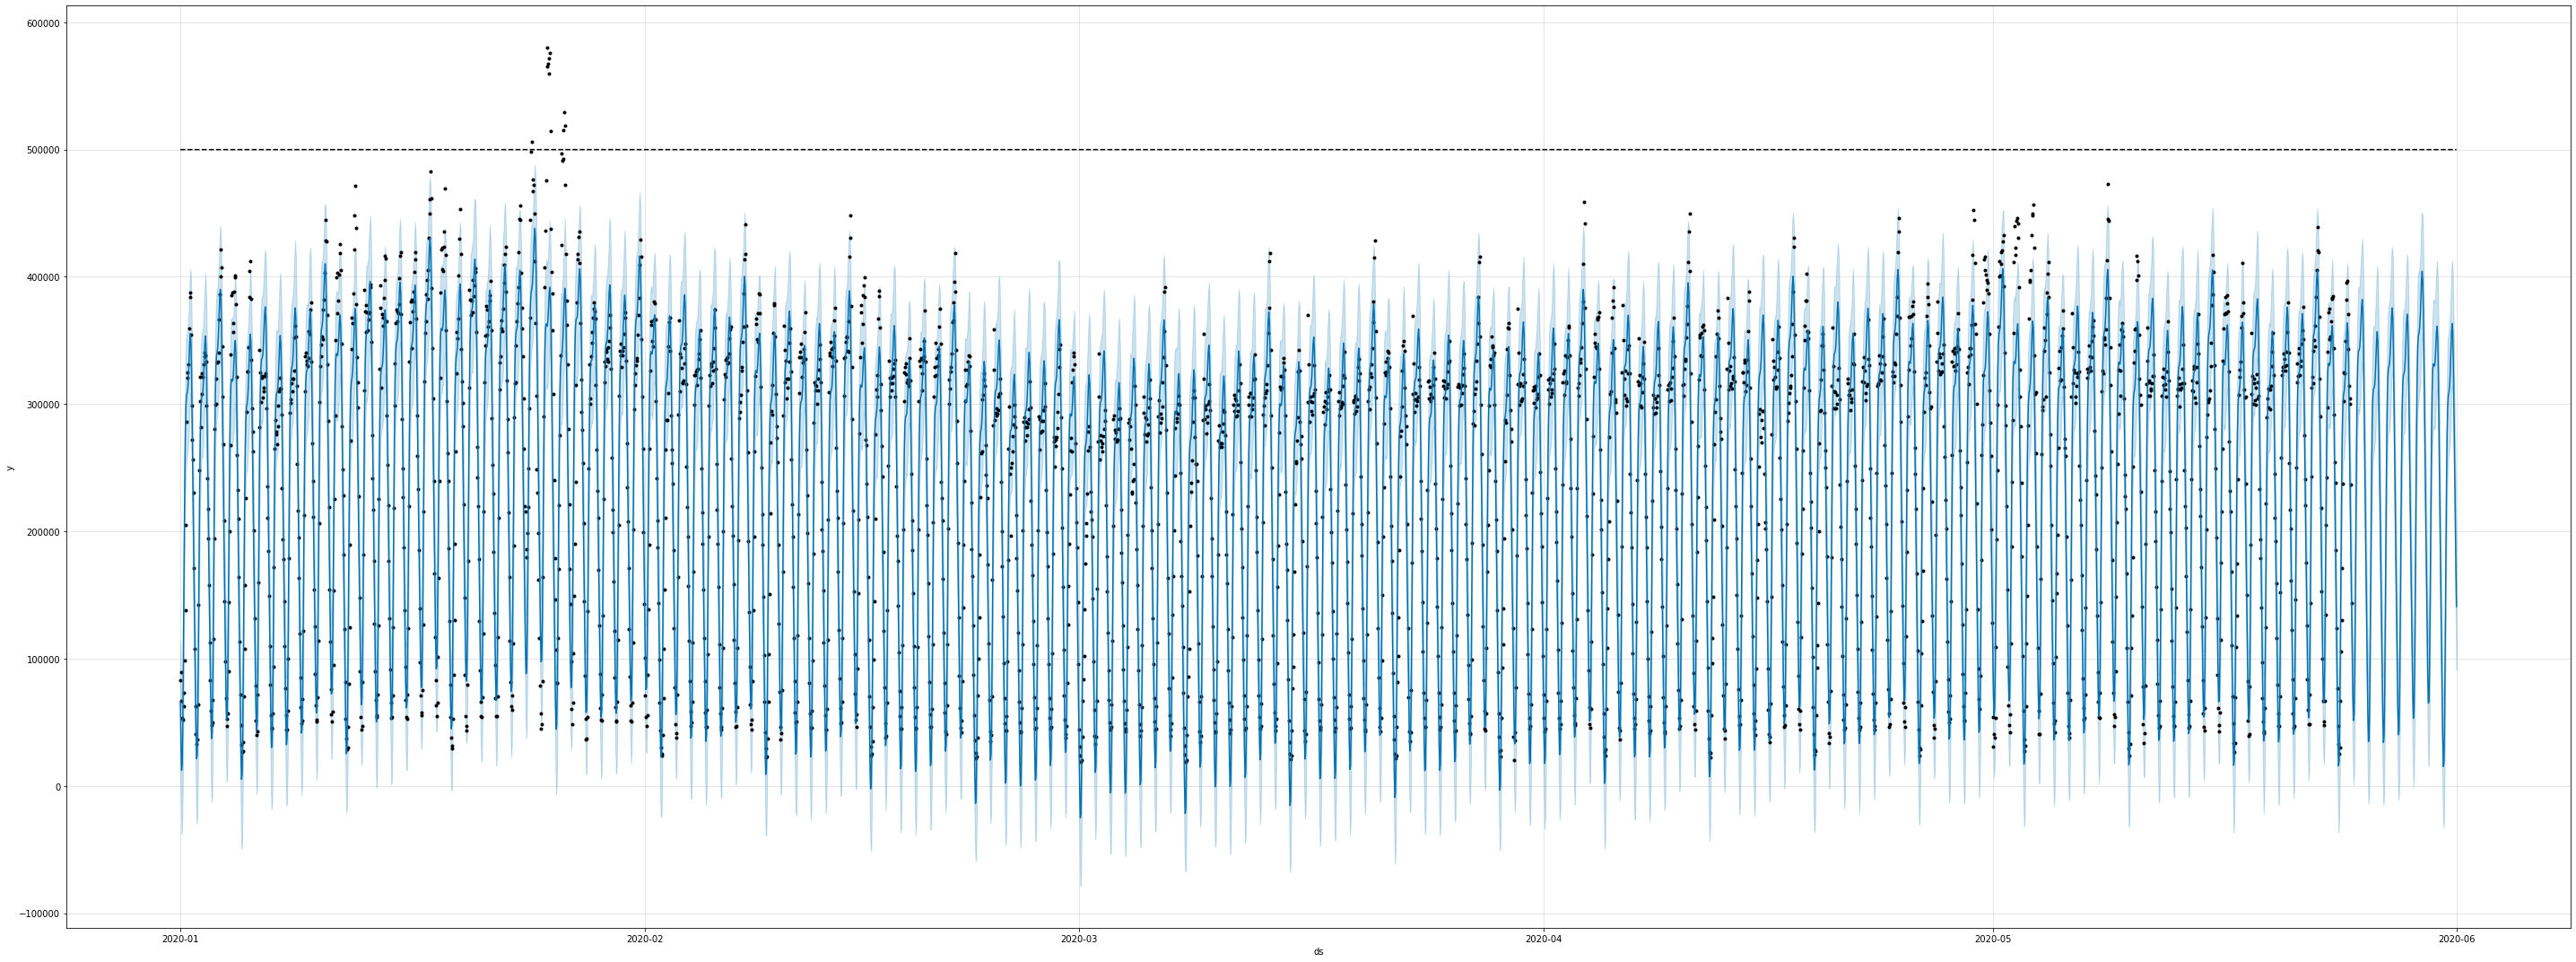

In [23]:
fig1 = m.plot(forecast,
             figsize=(40, 15),
              plot_cap=True
          )

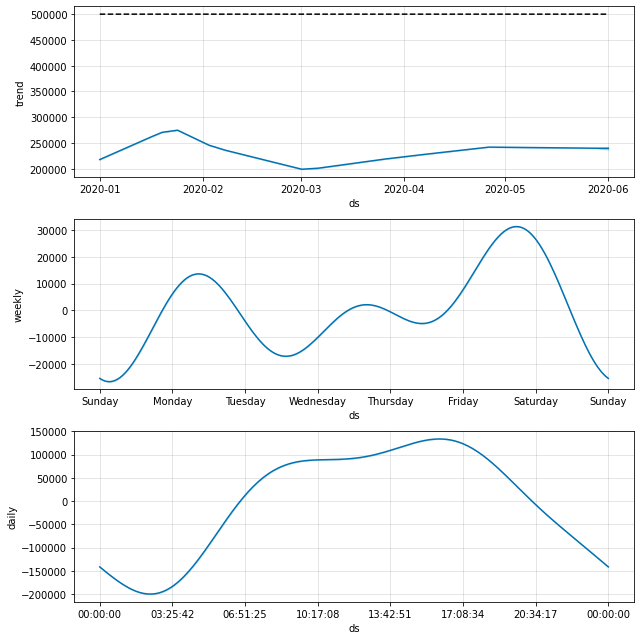

In [24]:
fig2 = m.plot_components(forecast)

### Trend Change Points

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -153.355
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7644.59     0.0498662       497.151           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7654.45    0.00540013       75.1318           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        7658.6    0.00041223        123.99      0.5317      0.5317      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     397        7659.6   0.000306827       150.438   3.234e-06       0.001      512  LS failed, Hessian reset 
     399       7659.61   3.56329e-05       91.0876      0.8228      0.8228      514   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7660.04   0.000106538    

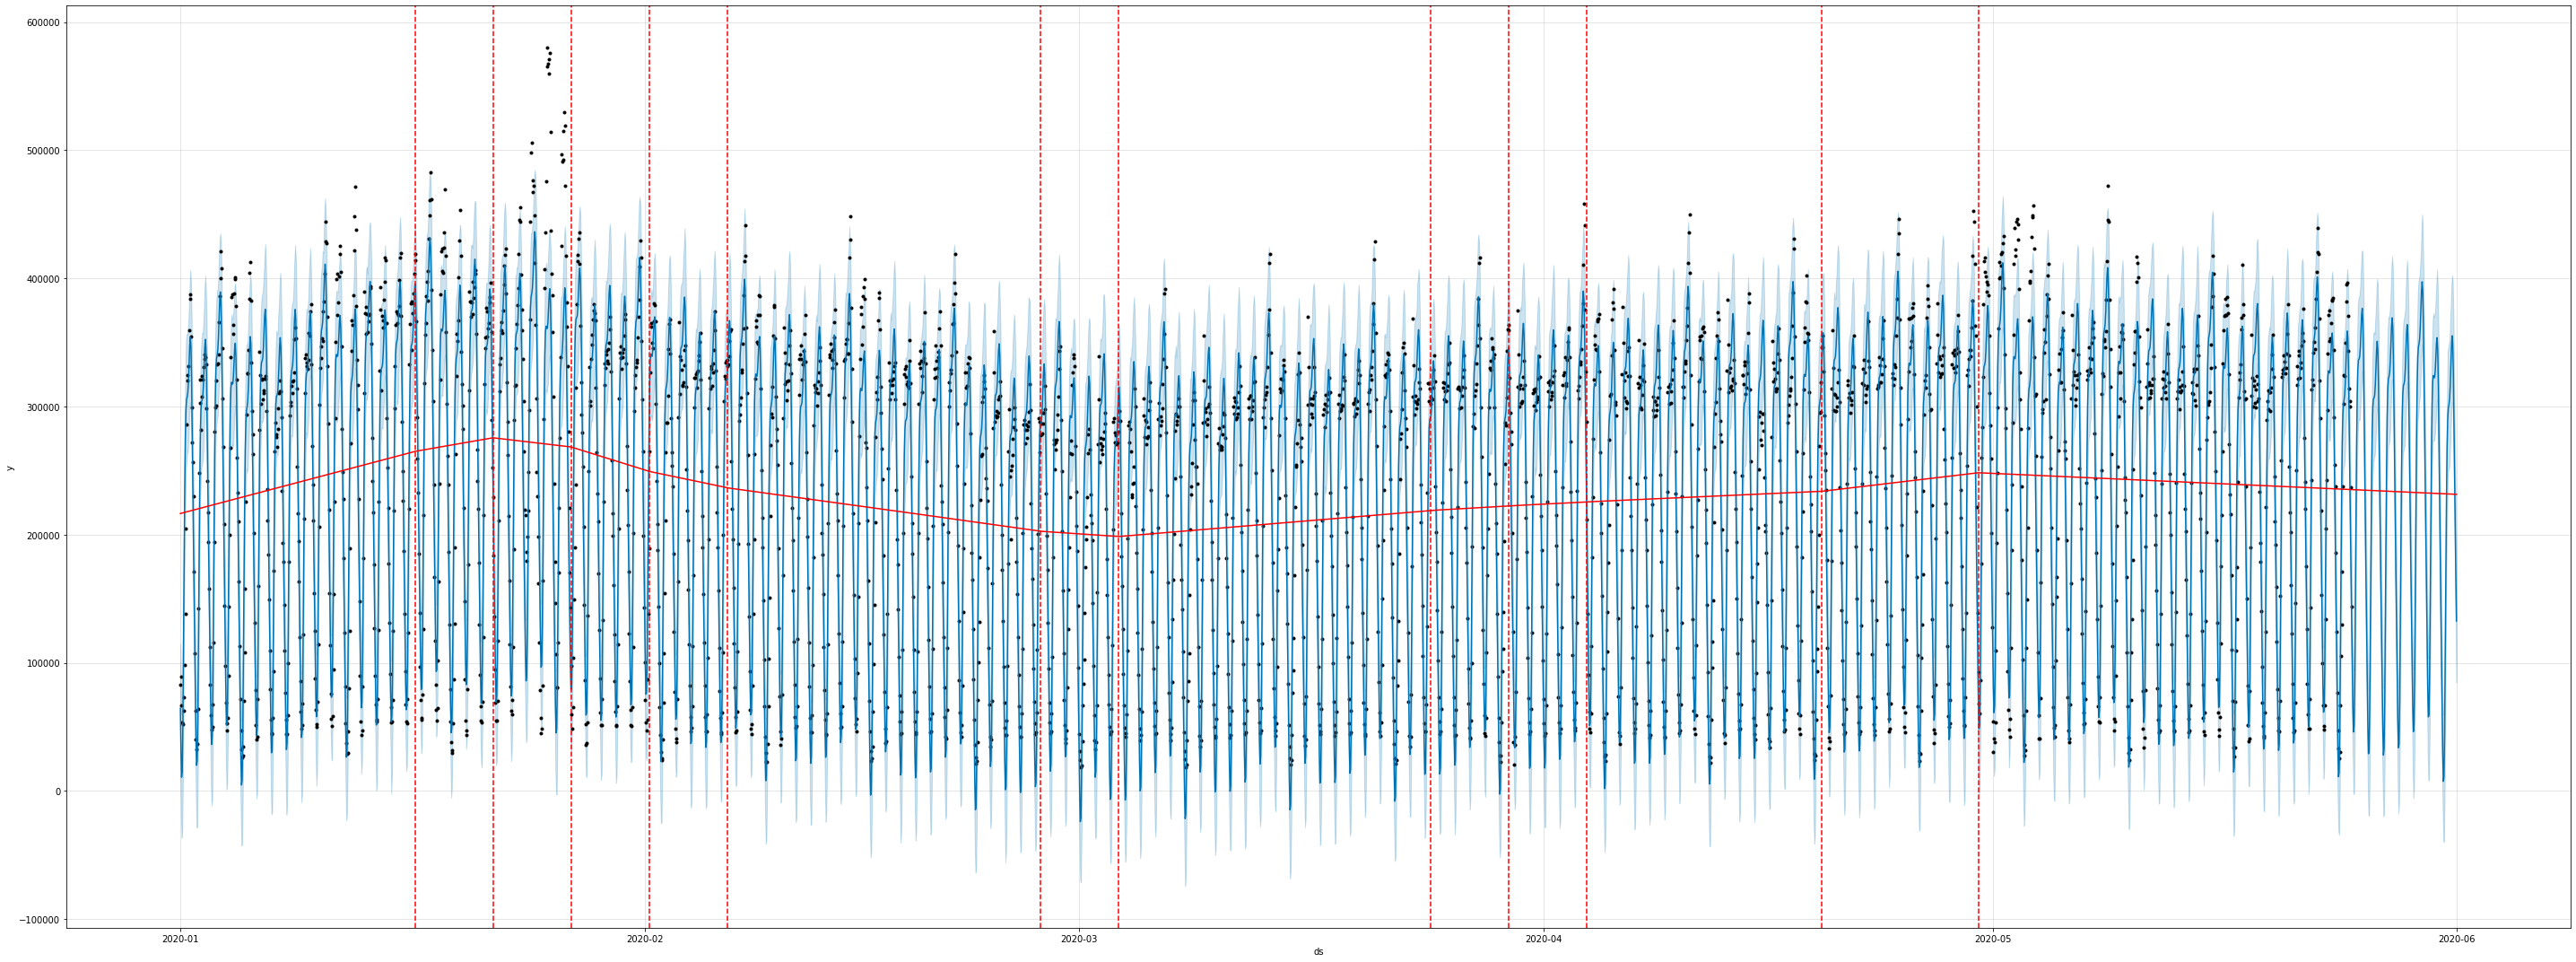

In [25]:
from fbprophet.plot import add_changepoints_to_plot

# Prophet 객체 선언
m = Prophet(
    changepoint_range=0.9,
    changepoint_prior_scale=0.07
)

# model 학습
m.fit(new_df)

# 예측값 설정
future = m.make_future_dataframe(periods=168, freq='H')

# predict
forecast = m.predict(future)
fig = m.plot(forecast,
            figsize=(40, 15))
a = add_changepoints_to_plot(fig.gca(), m, forecast)

### hoilday

|날짜|명|
|--|--|
|2020-01-01|새해|
|2020-01-24|설날|
|2020-01-25|설날|
|2020-01-26|설날|
|2020-01-27|설날대체휴일
|2020-03-01|삼일절
|2020-04-15|국회의원선거
|2020-04-30|부처님오신날
|2020-05-05|어린이날
|2020-06-06|현충일
|2020-08-15|광복절
|2020-08-17|임시공휴일
|2020-09-30|추석
|2020-10-01|추석
|2020-10-02|추석
|2020-10-03|개천절
|2020-10-09|한글날
|2020-12-25|크리스마스

In [19]:
def create_timestamp(date):
    result = []
    
    for i in range(0, 24):
        result.append(date + ' ' + str(i).zfill(2) + ':00:00')
    
    return result

newyear = pd.DataFrame({
    'ds': pd.to_datetime(create_timestamp('2020-01-01')),
    'holiday': 'newyear'
})

seol = pd.DataFrame({
    'ds': pd.to_datetime(create_timestamp('2020-01-24') + create_timestamp('2020-01-25') + create_timestamp('2020-01-26')),
    'holiday': 'seol'
})

seol_alter = pd.DataFrame({
    'ds': pd.to_datetime(create_timestamp('2020-01-27')),
    'holiday': 'seol_alter'
})

day31 = pd.DataFrame({
    'ds': pd.to_datetime(create_timestamp('2020-03-01')),
    'holiday': 'day31'
})

election = pd.DataFrame({
    'ds': pd.to_datetime(create_timestamp('2020-04-15')),
    'holiday': 'election'
})

budda_day = pd.DataFrame({
    'ds': pd.to_datetime(create_timestamp('2020-04-30')),
    'holiday': 'budda_day'
})

children_day = pd.DataFrame({
    'ds': pd.to_datetime(create_timestamp('2020-05-05')),
    'holiday': 'children_day'
})

# memorial_day = pd.DataFrame({
#     'hoilday': 'memorial_day',
#     'ds': pd.to_datetime(create_timestamp('2020-06-06')),
# })

# independence_day = pd.DataFrame({
#     'hoilday': 'independence_day',
#     'ds': pd.to_datetime(create_timestamp('2020-08-15')),
# })

# temp_hoilday = pd.DataFrame({
#     'hoilday': 'temp_hoilday',
#     'ds': pd.to_datetime(create_timestamp('2020-08-17')),
# })

# thanksgiving_day = pd.DataFrame({
#     'hoilday': 'thanksgiving_day',
#     'ds': pd.to_datetime(create_timestamp('2020-09-30'), create_timestamp('2020-10-01'), create_timestamp('2020-10-02')),
# })

# foundation_day = pd.DataFrame({
#     'hoilday': 'foundation_day',
#     'ds': pd.to_datetime(create_timestamp('2020-10-03')),
# })

In [20]:
holidays = pd.concat((newyear, seol, seol_alter, day31, election, budda_day, children_day))

In [21]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216 entries, 0 to 23
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ds       216 non-null    datetime64[ns]
 1   holiday  216 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 5.1+ KB


In [22]:
# Prophet 객체 선언
m = Prophet(
    holidays=holidays
)

# model 학습
m.fit(new_df)

# 예측값 설정
future = m.make_future_dataframe(periods=168, freq='H')

# predict
forecast = m.predict(future)
fig = m.plot(forecast,
            figsize=(40, 15))

fig = m.plot_components(forecast)

NameError: name 'new_df' is not defined

## hyperparameter tuning

cluster num : 0  road nums : 13  
 road : [('101', '남해선(영암-순천)'), ('120', '광주대구선'), ('121', '무안광주선'), ('140', '고창담양선'), ('160', '울산선'), ('201', '익산장수선'), ('251', '호남선'), ('270', '순천완주선'), ('301', '당진대전선'), ('550', '중앙선'), ('652', '동해선(부산-포항)'), ('1020', '남해1지선'), ('2510', '호남지선')]
 
cluster num : 1  road nums : 16    
 road : [('10', '경부선'), ('100', '남해선(순천-부산)'), ('150', '서해안선'), ('352', '중부선'), ('370', '제2 중부선'), ('400', '평택제천선'), ('450', '중부내륙선'), ('500', '영동선'), ('1000', '서울외곽순환선'), ('1040', '남해2지선'), ('1100', '제2경인선'), ('1200', '경인선'), ('3000', '대전남부선'), ('4510', '중부내륙지선'), ('5510', '중앙선지선'), ('6000', '부산외곽선')]

cluster num : 2  road nums : 6  
 road : [('200', '대구포항선'), ('300', '청주영덕선'), ('351', '통영대전선'), ('600', '서울양양선'), ('650', '동해선(삼척-속초)'), ('1510', '서천공주선')]

In [41]:
cluster_0 = [('101', '남해선(영암-순천)'), ('120', '광주대구선'), ('121', '무안광주선'), ('140', '고창담양선'), ('160', '울산선'), ('201', '익산장수선'), ('251', '호남선'), ('270', '순천완주선'), ('301', '당진대전선'), ('550', '중앙선'), ('652', '동해선(부산-포항)'), ('1020', '남해1지선'), ('2510', '호남지선')]
cluster_1 = [('10', '경부선'), ('100', '남해선(순천-부산)'), ('150', '서해안선'), ('352', '중부선'), ('370', '제2 중부선'), ('400', '평택제천선'), ('450', '중부내륙선'), ('500', '영동선'), ('1000', '서울외곽순환선'), ('1040', '남해2지선'), ('1100', '제2경인선'), ('1200', '경인선'), ('3000', '대전남부선'), ('4510', '중부내륙지선'), ('5510', '중앙선지선'), ('6000', '부산외곽선')]
cluster_2 = [('200', '대구포항선'), ('300', '청주영덕선'), ('351', '통영대전선'), ('600', '서울양양선'), ('650', '동해선(삼척-속초)'), ('1510', '서천공주선')]

### cluster 0 tuning
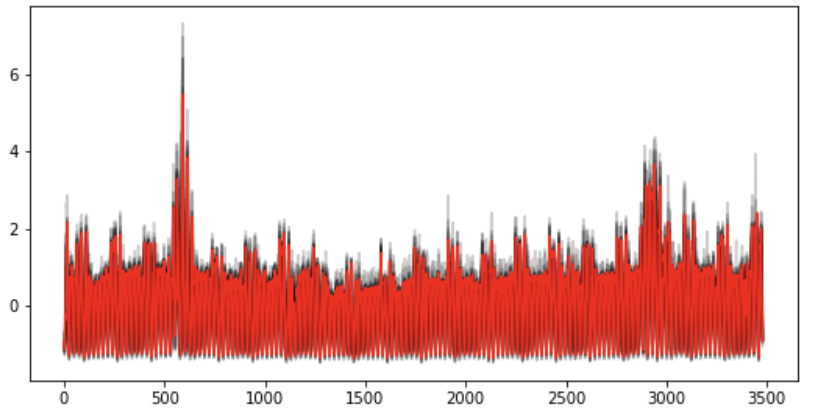

In [47]:
from fbprophet.diagnostics import cross_validation, performance_metrics
import itertools

num_list = [x[0] for x in cluster_0]
road = new_train[num_list].sum().idxmax()

# 중앙선
# road = '550'

new_df = pd.DataFrame({
    'ds':new_train['날짜'],
    'y':new_train[road]
})

In [70]:
name = 'cluster_0'

cluster_0_params = {
    'changepoint' : 0.06,
    'weekly' : 13,
    'daily' : 11,
    'holiday' : 24
    
}

In [71]:
for i in range(1):
    wandb.init(
        config=cluster_0_params,
        project='Prophet',
        tags=['holiday'],
        group='cluster 0',
        name= name,
        notes='중앙선',
        save_code=True,
    )

    m = Prophet(changepoint_prior_scale=cluster_0_params['changepoint'],
                weekly_seasonality=cluster_0_params['weekly'],
                daily_seasonality=cluster_0_params['daily'],
                holidays=holidays,
                holidays_prior_scale=cluster_0_params['holiday']
               )

    m.fit(new_df)
    df_cv = cross_validation(m, initial='14 days', period='7 days', horizon='7 days')
    df_p = performance_metrics(df_cv)

    print(df_p['rmse'].mean())

    wandb.log({
        'rmse':df_p['rmse'].mean()
    })
    wandb.finish()
    cluster_0_params['changepoint'] += 0.01

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 18 forecasts with cutoffs between 2020-01-19 23:00:00 and 2020-05-17 23:00:00


Initial log joint probability = -74.3015
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8316.47    0.00956899       236.876           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       8325.97   0.000161485        196.04   7.854e-07       0.001      269  LS failed, Hessian reset 
     199       8326.18    0.00221135       434.568           1           1      274   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        8329.7   0.000380825       223.987      0.3153           1      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     334        8330.5   0.000139094       79.5545   1.339e-06       0.001      472  LS failed, Hessian reset 
     399        8331.2   0.000734556       67.6986           1           1      548   
    Iter      log pro

Initial log joint probability = -33.2405
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       1154.59   0.000212939       73.3137   3.123e-06       0.001      166  LS failed, Hessian reset 
      99       1154.74    0.00129312       57.1817           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       1154.82   0.000282225       49.2043   5.079e-06       0.001      226  LS failed, Hessian reset 
     199       1155.47   0.000193038       53.8004           1           1      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1155.7   0.000315533       49.4362       0.194           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     350       1156.42   0.000299233       98.4132   2.252e-06       0.001      551  LS failed, Hessian rese

### cluster 1 tuning
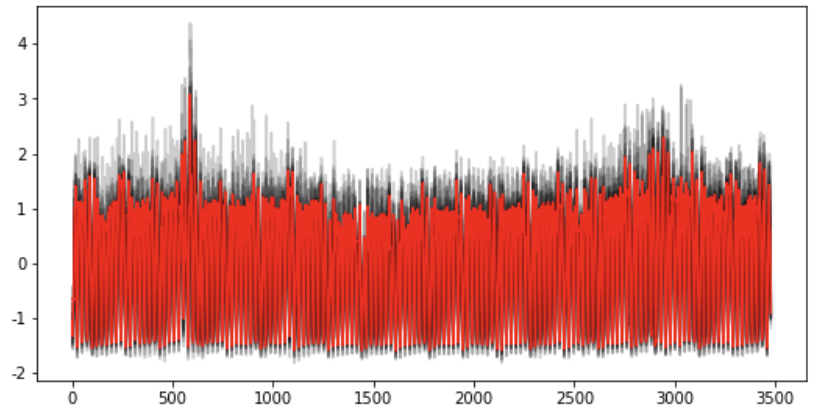

In [245]:
from fbprophet.diagnostics import cross_validation, performance_metrics
import itertools

num_list = [x[0] for x in cluster_1]
road = new_train[num_list].sum().idxmax()

new_df = pd.DataFrame({
    'ds':new_train['날짜'],
    'y':new_train[road]
})

In [246]:
m = Prophet(changepoint_prior_scale=0.12, weekly_seasonality=14, daily_seasonality=12, holidays_prior_scale=10)

m.fit(new_df)
df_cv = cross_validation(m, initial='14 days', period='7 days', horizon='7 days')
df_p = performance_metrics(df_cv)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 18 forecasts with cutoffs between 2020-01-19 23:00:00 and 2020-05-17 23:00:00


Initial log joint probability = -153.355
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8479.86    0.00390707       845.944           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8553.13     0.0073985       582.956           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8573.75    0.00550936       754.055           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        8586.3    0.00618905       428.736       1.176      0.1176      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8599.04    0.00696353       471.998           1           1      564   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -34.327
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1174.85   0.000378692       25.6271           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1175.56   0.000191395       34.3555      0.6382      0.6382      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     276       1175.66   0.000282314       69.0041   8.376e-06       0.001      370  LS failed, Hessian reset 
     299       1175.72   5.75377e-05       27.8879      0.7152      0.7152      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     357        1175.8    0.00012864       30.8827   3.744e-06       0.001      501  LS failed, Hessian reset 
     394       1175.81   4.76039e-06        21.648   1.596e-07       0.001      592  LS failed, Hessian reset

In [247]:
df_p['rmse'].mean()

55100.42723200352

- changepoint_prior_scale=0.05, weekly_seasonality=10, daily_seasonality=10, holidays_prior_scale=10 = 51962.28894990847 (base)

- changepoint_prior_scale=0.05, weekly_seasonality=10, daily_seasonality=10, holidays_prior_scale=13 = 51962.28894990847
- changepoint_prior_scale=0.05, weekly_seasonality=10, daily_seasonality=15, holidays_prior_scale=10 = 51956.31333571868

- changepoint_prior_scale=0.05, weekly_seasonality=13, daily_seasonality=10, holidays_prior_scale=10 = 51617.81770996418
- changepoint_prior_scale=0.05, weekly_seasonality=14, daily_seasonality=10, holidays_prior_scale=10 = 51541.32110611056 
- changepoint_prior_scale=0.05, weekly_seasonality=15, daily_seasonality=10, holidays_prior_scale=10 = 51669.55036011705 

- changepoint_prior_scale=0.05, weekly_seasonality=15, daily_seasonality=10, holidays_prior_scale=10 = 51669.55036011705 
- changepoint_prior_scale=0.08, weekly_seasonality=15, daily_seasonality=10, holidays_prior_scale=10 = 53887.75544833499
- changepoint_prior_scale=0.1, weekly_seasonality=15, daily_seasonality=10, holidays_prior_scale=10 = 54173.31673722772

- changepoint_prior_scale=0.05, weekly_seasonality=15, daily_seasonality=10, holidays_prior_scale=10 = 51669.55036011705 
- changepoint_prior_scale=0.05, weekly_seasonality=15, daily_seasonality=10, holidays_prior_scale=13 = 51669.55036011705

- changepoint_prior_scale=0.05, weekly_seasonality=14, daily_seasonality=10, holidays_prior_scale=10 = 51541.32110611056 
- changepoint_prior_scale=0.06, weekly_seasonality=14, daily_seasonality=10, holidays_prior_scale=10 = 52700.350253171026

- changepoint_prior_scale=0.05, weekly_seasonality=14, daily_seasonality=9, holidays_prior_scale=10 = 52336.18660252246
- changepoint_prior_scale=0.05, weekly_seasonality=14, daily_seasonality=10, holidays_prior_scale=10 = 51541.32110611056 
- changepoint_prior_scale=0.05, weekly_seasonality=14, daily_seasonality=11, holidays_prior_scale=10 = 51478.762958702646 
- changepoint_prior_scale=0.05, weekly_seasonality=14, daily_seasonality=12, holidays_prior_scale=10 = 51463.64797321109 (best)
- changepoint_prior_scale=0.05, weekly_seasonality=14, daily_seasonality=13, holidays_prior_scale=10 = 51626.172547155256

- changepoint_prior_scale=0.05, weekly_seasonality=14, daily_seasonality=12, holidays_prior_scale=10 = 51463.64797321109 (best)
- changepoint_prior_scale=0.06, weekly_seasonality=14, daily_seasonality=12, holidays_prior_scale=10 = 52657.450830956455

- changepoint_prior_scale=0.05, weekly_seasonality=14, daily_seasonality=12, holidays_prior_scale=5 = 51463.64797321109
- changepoint_prior_scale=0.05, weekly_seasonality=14, daily_seasonality=12, holidays_prior_scale=10 = 51463.64797321109 (best)
- changepoint_prior_scale=0.05, weekly_seasonality=14, daily_seasonality=12, holidays_prior_scale=20 = 51463.64797321109 

weekly
- changepoint_prior_scale=0.05, weekly_seasonality=9, daily_seasonality=12, holidays_prior_scale=10 = 
- changepoint_prior_scale=0.05, weekly_seasonality=10, daily_seasonality=12, holidays_prior_scale=10 = 
- changepoint_prior_scale=0.05, weekly_seasonality=14, daily_seasonality=12, holidays_prior_scale=10 = 51463.64797321109 (best)



- changepoint_prior_scale=0.12, weekly_seasonality=17, daily_seasonality=15, holidays_prior_scale=16 = 55032.70224886119

### cluster 2 tuning
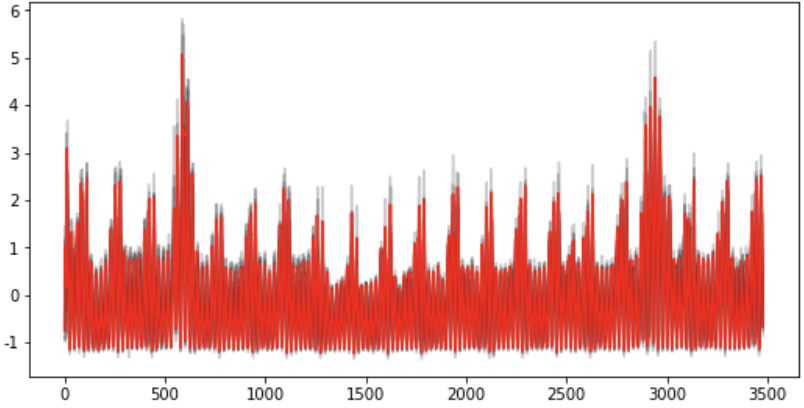
- 주말간 영향을 많이 받는 특징이 보임

In [187]:
from fbprophet.diagnostics import cross_validation, performance_metrics
import itertools

num_list = [x[0] for x in cluster_2]
road = new_train[num_list].sum().idxmax()

new_df = pd.DataFrame({
    'ds':new_train['날짜'],
    'y':new_train[road]
})

In [188]:
m = Prophet(changepoint_prior_scale=0.05, weekly_seasonality=6, daily_seasonality=12, holidays_prior_scale=20)

m.fit(new_df)
df_cv = cross_validation(m, initial='14 days', period='7 days', horizon='7 days')
df_p = performance_metrics(df_cv)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 18 forecasts with cutoffs between 2020-01-19 23:00:00 and 2020-05-17 23:00:00


Initial log joint probability = -68.5125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7680.97     0.0331727       661.312           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7704.11     0.0115019       513.028           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     287       7714.03   9.20802e-05       117.441   1.121e-06       0.001      382  LS failed, Hessian reset 
     299       7714.28    0.00105701       108.624      0.8955      0.8955      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317        7714.9   0.000422979       304.004    2.82e-06       0.001      464  LS failed, Hessian reset 
     399       7717.49    0.00153876       132.548           1           1      566   
    Iter      log pro

Initial log joint probability = -30.8244
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1002.41    0.00136443       85.2298      0.5526      0.5526      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       1002.94    0.00357088       112.358   4.889e-05       0.001      221  LS failed, Hessian reset 
     187       1003.82   0.000285362       50.9822   6.124e-06       0.001      346  LS failed, Hessian reset 
     199       1003.84   9.21816e-05       52.8493      0.2342      0.8491      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       1003.86    5.8593e-05        67.564    1.07e-06       0.001      446  LS failed, Hessian reset 
     247       1003.86   6.42533e-08       52.2876     0.01355           1      482   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

In [189]:
df_p['rmse'].mean()

17104.37886918634

- changepoint_prior_scale=0.05, weekly_seasonality=7, daily_seasonality=10, holidays_prior_scale=9 = 17166.859209813163 

daily
- changepoint_prior_scale=0.05, weekly_seasonality=6, daily_seasonality=8, holidays_prior_scale=10 = 17181.465092153197
- changepoint_prior_scale=0.05, weekly_seasonality=6, daily_seasonality=9, holidays_prior_scale=10 = 17107.248465489065 
- changepoint_prior_scale=0.05, weekly_seasonality=6, daily_seasonality=10, holidays_prior_scale=10 = 17121.9933835472 
- changepoint_prior_scale=0.05, weekly_seasonality=6, daily_seasonality=11, holidays_prior_scale=10 = 17113.52916445827
- changepoint_prior_scale=0.05, weekly_seasonality=6, daily_seasonality=12, holidays_prior_scale=10 = 17104.37886918634 (best)

- changepoint_prior_scale=0.05, weekly_seasonality=6, daily_seasonality=12, holidays_prior_scale=10 = 17104.37886918634 (best)
- changepoint_prior_scale=0.05, weekly_seasonality=6, daily_seasonality=12, holidays_prior_scale=20 = 17104.37886918634

- changepoint_prior_scale=0.05, weekly_seasonality=5, daily_seasonality=10, holidays_prior_scale=10 = 17154.441308793746
- changepoint_prior_scale=0.05, weekly_seasonality=6, daily_seasonality=10, holidays_prior_scale=10 = 17121.9933835472
- changepoint_prior_scale=0.05, weekly_seasonality=7, daily_seasonality=10, holidays_prior_scale=10 = 17166.859209813163 
- changepoint_prior_scale=0.05, weekly_seasonality=8, daily_seasonality=10, holidays_prior_scale=10 = 17195.2969134383 
- changepoint_prior_scale=0.05, weekly_seasonality=9, daily_seasonality=10, holidays_prior_scale=10 = 17270.652730568087 
- changepoint_prior_scale=0.05, weekly_seasonality=10, daily_seasonality=10, holidays_prior_scale=10 = 17315.58472258222
- changepoint_prior_scale=0.05, weekly_seasonality=15, daily_seasonality=10, holidays_prior_scale=10 = 17310.650762128706 


- changepoint_prior_scale=0.05, weekly_seasonality=10, daily_seasonality=15, holidays_prior_scale=10 = 17354.955221436034
- changepoint_prior_scale=0.05, weekly_seasonality=10, daily_seasonality=10, holidays_prior_scale=15 = 17315.58472258222

- changepoint_prior_scale=0.05, weekly_seasonality=18, daily_seasonality=10, holidays_prior_scale=13 = 17693.356086182095
- changepoint_prior_scale=0.08, weekly_seasonality=18, daily_seasonality=10, holidays_prior_scale=13 = 18218.0894172749

- changepoint_prior_scale=0.12, weekly_seasonality=17, daily_seasonality=15, holidays_prior_scale=16 = 18361.373539714372

## Inference per cluster

In [266]:
params_0 = {
    'changepoint_prior_scale':0.05,
    'weekly_seasonality':10,
    'daily_seasonality':10,
    'holidays_prior_scale':24
}

params_1 = {
    'changepoint_prior_scale':0.05,
    'weekly_seasonality':14,
    'daily_seasonality':10,
    'holidays_prior_scale':10
}

params_2 = {
    'changepoint_prior_scale':0.05,
    'weekly_seasonality':6,
    'daily_seasonality':12,
    'holidays_prior_scale':10
}

In [269]:
submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))

In [270]:
def roadcluster_prophet_predict(df, cluster, holidays, params, submission):
    roads = [x[0] for x in cluster]
    
    for road in roads:
        print('-' * 15, 'road : ', road, '-' * 15)
        # dataframe
        new_df = pd.DataFrame({
            'ds':new_train['날짜'],
            'y':new_train[road]
        })
        new_df['floor'] = 55
        # model
        model = Prophet(
            holidays=holidays,
            **params
        )
        model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        # fit
        model.fit(new_df)
        
        # cv
        # df_cv = cross_validation(m, initial='14 days', period='7 days', horizon='7 days')
        
        # forecast
        future = model.make_future_dataframe(periods=168, freq='H')
        future['floor'] = 55
        forecast = model.predict(future)
        
        # submission
        fore = forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']][-168:]
        submission[road] = fore['yhat'].values
        
    return submission
    

In [271]:
submission = roadcluster_prophet_predict(new_train, cluster_0, holidays, params_1, submission)
submission = roadcluster_prophet_predict(new_train, cluster_1, holidays, params_1, submission)
submission = roadcluster_prophet_predict(new_train, cluster_2, holidays, params_1, submission)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  101 ---------------
Initial log joint probability = -46.2335
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9273.47     0.0107927       573.168           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       9276.14   9.03803e-05       126.886   6.341e-07       0.001      225  LS failed, Hessian reset 
     199       9277.15   0.000308226       128.388           1           1      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       9277.75   7.13213e-05       206.005   2.237e-07       0.001      356  LS failed, Hessian reset 
     299       9278.35    0.00134843       109.226           1           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     356       9278.98   0.000184225       185.957   2.687e-06  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  120 ---------------
Initial log joint probability = -43.6134
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9341.03    0.00609611       728.211           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        9350.6    0.00144361       225.219      0.9126      0.9126      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9353.38    0.00209987       286.823      0.9581      0.9581      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9354.53    0.00141912       241.651           1           1      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        9355.3   0.000458552       172.856           1           1      586   
    Iter      log pr

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  121 ---------------
Initial log joint probability = -141.803
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8263.91    0.00078736       389.341      0.5048      0.5048      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       8264.66   0.000133726       133.191   1.638e-06       0.001      182  LS failed, Hessian reset 
     199        8265.4   0.000452745       117.422           1           1      273   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8266.59    0.00196608       157.518      0.3771           1      391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8267.02   0.000143812        56.433       0.694       0.694      524   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Not

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  140 ---------------
Initial log joint probability = -73.9642
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8698.34    0.00299563        231.62      0.6368      0.6368      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8700.91    0.00024872       131.865      0.3438      0.3438      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8702.09    0.00129344       142.327           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351       8702.83   4.81227e-05       102.527   3.081e-07       0.001      467  LS failed, Hessian reset 
     399       8703.19   0.000158985       74.9962      0.4292           1      532   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Not

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  160 ---------------
Initial log joint probability = -133.254
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8582.96     0.0100294       1165.72           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       8590.88   5.52489e-05       89.3761   2.594e-07       0.001      249  LS failed, Hessian reset 
     199       8592.64    0.00028184       86.9272           1           1      273   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8596.48    0.00034856       106.846      0.3003           1      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     366       8597.05   0.000208823        202.21   2.195e-06       0.001      527  LS failed, Hessian reset 
     399       8597.07    4.9694e-05       73.7412           1  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  201 ---------------
Initial log joint probability = -56.1866
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9268.93     0.0011007       124.162           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9274.29   0.000742086       87.5787      0.8733      0.8733      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     270       9275.79     5.796e-05       173.605   2.276e-07       0.001      355  LS failed, Hessian reset 
     299       9276.16   0.000238599       135.056           1           1      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9277.04    0.00108515       282.657           1           1      497   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Not

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  251 ---------------
Initial log joint probability = -117.271
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        8960.4    0.00618518       696.904           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8974.65   0.000618764        269.74           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       8977.98   0.000116381       294.698   3.833e-07       0.001      390  LS failed, Hessian reset 
     299       8978.19    0.00170938       228.616           1           1      395   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     363        8978.7   4.03578e-05       104.159   4.379e-07       0.001      535  LS failed, Hessian reset 
     399       8978.82   0.000172052       115.901           1  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  270 ---------------
Initial log joint probability = -77.7509
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8500.93    0.00305548       797.267           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8518.34   0.000643625       152.773           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8522.01   0.000199105       225.859      0.1636      0.1636      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     396       8523.85   0.000115791       183.561   8.297e-07       0.001      519  LS failed, Hessian reset 
     399        8523.9   0.000506195       233.374           1           1      522   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Not

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  301 ---------------
Initial log joint probability = -93.0779
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8077.68     0.0328923       668.809           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8088.15    0.00126165       155.293      0.4309      0.4309      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       8088.37   0.000120057       183.438   4.403e-07       0.001      294  LS failed, Hessian reset 
     233       8089.34   9.12866e-05       87.2437   1.252e-06       0.001      378  LS failed, Hessian reset 
     299       8089.98   0.000300693       82.4664           1           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8090.24    0.00164715       88.8587           1  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  550 ---------------
Initial log joint probability = -74.3015
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8375.92     0.0204263       447.501           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8389.57    0.00227183       222.468           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       8392.16   0.000378395        465.22   1.536e-06       0.001      322  LS failed, Hessian reset 
     299       8395.57    0.00116237       162.659           1           1      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8397.07    0.00010944       89.9959      0.5001      0.5001      514   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Not

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  652 ---------------
Initial log joint probability = -50.8797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9385.29   0.000527505       207.024           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196        9390.9   0.000113874       250.968   8.943e-07       0.001      283  LS failed, Hessian reset 
     199       9390.94   0.000247039       209.502           1           1      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        9392.1    0.00164501       93.4094           1           1      404   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9393.16   8.93529e-05        74.525           1           1      533   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Not

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  1020 ---------------
Initial log joint probability = -115.239
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7889.22    0.00542632       116.856           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       7893.22   9.02575e-05       88.6824    3.76e-07       0.001      310  LS failed, Hessian reset 
     199        7893.4    0.00138255       215.531      0.9317      0.9317      315   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7893.93   0.000439092       78.6168           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311        7894.1   0.000127927       159.126   1.061e-06       0.001      498  LS failed, Hessian reset 
     366       7894.31   1.84111e-05       64.4184   2.261e-07 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  2510 ---------------
Initial log joint probability = -155.609
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7944.21    0.00856068        397.17           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       7949.85    0.00011193       162.329   5.133e-07       0.001      276  LS failed, Hessian reset 
     199       7950.49    0.00274527       255.947           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7951.77   0.000170237       76.6814      0.2631      0.2631      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     342       7951.97   9.14182e-05       130.611   1.037e-06       0.001      495  LS failed, Hessian reset 
     399       7952.13   0.000243171       59.7336      0.6757 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  10 ---------------
Initial log joint probability = -153.355
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        8716.6    0.00443695       758.649           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8740.57    0.00119486       556.544           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8750.01    0.00167486       190.055      0.7792      0.7792      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8752.79    0.00189987       184.328      0.6034      0.6034      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8755.43    0.00228961       91.6629      0.1647           1      596   
    Iter      log pro

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  100 ---------------
Initial log joint probability = -162.161
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8707.51    0.00111872        191.48           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8715.41    0.00221677       154.122           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8718.49   0.000159751       57.7977      0.6896      0.6896      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8719.82   0.000241226       73.4789       0.437           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     410       8719.86   6.82615e-05       136.819   7.134e-07       0.001      521  LS failed, Hessian res

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  150 ---------------
Initial log joint probability = -135.612
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8679.41     0.0228171        596.75           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        8698.6    0.00730436       240.486      0.7673      0.7673      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8706.27    0.00565842       341.104           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        8708.7    0.00255338       120.578           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8711.65    0.00113929       109.848           1           1      584   
    Iter      log pr

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  352 ---------------
Initial log joint probability = -169.048
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8029.08    0.00821375       689.637           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8064.74    0.00178381       435.674      0.6015      0.6015      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8070.17     0.0016952       172.669      0.4318           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     367       8070.71   0.000536409        308.39   6.966e-06       0.001      484  LS failed, Hessian reset 
     399       8070.95   0.000133863       108.589           1           1      522   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Not

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  370 ---------------
Initial log joint probability = -200.082
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7517.44    0.00258532        254.49      0.7689      0.7689      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       7520.68   0.000148281       150.866   8.002e-07       0.001      267  LS failed, Hessian reset 
     199       7521.38   0.000674546        73.171           1           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7522.98     0.0001113       87.7186      0.3008      0.3008      429   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7523.53   0.000211727       117.508           1           1      554   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Not

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  400 ---------------
Initial log joint probability = -138.348
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8357.86    0.00402051        240.52           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8361.43   0.000215727       99.7345      0.5356      0.5356      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     273       8362.44   0.000173865       83.4252   2.777e-06       0.001      368  LS failed, Hessian reset 
     299       8362.49    0.00175057       126.089           1           1      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     308       8362.84   0.000203537        241.57   1.121e-06       0.001      455  LS failed, Hessian reset 
     399       8363.59   3.57968e-05       65.5567           1  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  450 ---------------
Initial log joint probability = -93.0807
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8874.94    0.00766668       541.701           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        8894.2    0.00239199        122.74           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8898.03    0.00246467       367.541           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8902.11      0.019788       290.364       3.673      0.3673      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     407        8902.8    0.00164693        484.06   1.112e-05       0.001      518  LS failed, Hessian res

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  500 ---------------
Initial log joint probability = -120.646
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8793.46    0.00320199       770.556           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8810.32    0.00438861       310.985           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8817.59    0.00148804       245.381           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     338       8819.36   6.56498e-05       162.025   4.284e-07       0.001      439  LS failed, Hessian reset 
     387       8820.37   0.000225071       92.1307   1.654e-06       0.001      533  LS failed, Hessian reset 
     399       8820.49    0.00026849        162.81           1  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  1000 ---------------
Initial log joint probability = -261.394
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7674.28   0.000930865       70.0182           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       7674.68   0.000145287       90.4963   2.014e-06       0.001      216  LS failed, Hessian reset 
     167       7674.71   0.000109842       87.9763   1.699e-06       0.001      305  LS failed, Hessian reset 
     194       7674.72   5.17901e-05       63.1116   9.427e-07       0.001      395  LS failed, Hessian reset 
     199       7674.73   2.13872e-06       47.3974      0.2726      0.9022      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       7674.73   4.04873e-07       48.8146           1           1      414   
Optimization terminated normally: 
  Converg

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  1040 ---------------
Initial log joint probability = -224.468
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8380.36    0.00242932       265.456      0.5298      0.5298      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8382.25   5.32967e-05       84.8565      0.8008      0.8008      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     235        8382.7      0.000338       271.352    1.56e-06       0.001      318  LS failed, Hessian reset 
     299       8383.02   1.05954e-06       76.2513      0.0616           1      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8383.12    0.00548819       96.3844      0.6381           1      523   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  No

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  1100 ---------------
Initial log joint probability = -159.989
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7815.87      0.063229       1329.17           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        7860.6     0.0280685       660.981           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       7867.18   0.000205287       253.458   8.509e-07       0.001      292  LS failed, Hessian reset 
     299       7874.18   0.000407233       241.285      0.5404      0.5404      376   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7879.37    0.00163506       152.316           1           1      493   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  No

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  1200 ---------------
Initial log joint probability = -140.888
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7991.11   0.000900524        234.29      0.8878      0.8878      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7995.23   0.000353862       145.194      0.7558      0.7558      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       7995.33   4.89098e-05       70.2481   4.278e-07       0.001      300  LS failed, Hessian reset 
     299        7997.2   0.000115289       79.6983      0.4117      0.4117      407   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7998.97    0.00503599       127.502           1           1      528   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  No

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  3000 ---------------
Initial log joint probability = -109.707
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7407.72      0.137821       533.542           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7420.34    0.00304126       170.501           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224        7421.8   0.000135724       150.508   9.851e-07       0.001      306  LS failed, Hessian reset 
     245       7423.34   0.000237293       202.206   1.562e-06       0.001      373  LS failed, Hessian reset 
     269       7423.85   0.000174736       129.668    2.65e-06       0.001      439  LS failed, Hessian reset 
     299       7424.15     0.0289671       325.337           1           1      482   
    Iter      log prob        ||dx||      ||

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  4510 ---------------
Initial log joint probability = -160.58
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8017.14    0.00182097       158.998      0.3308       0.698      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8022.06    0.00053965        149.64           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     281       8022.64   6.07561e-05        94.989   6.452e-07       0.001      393  LS failed, Hessian reset 
     299       8022.74    0.00026416       85.9713           1           1      414   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8023.39    0.00143462       89.8007           1           1      529   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Not

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  5510 ---------------
Initial log joint probability = -228.653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        7619.2    0.00160676       181.091           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        7625.8    0.00221846       204.574       3.603           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     298       7626.91   8.97775e-05       109.031   7.088e-07       0.001      392  LS failed, Hessian reset 
     299       7626.92   6.05732e-05       100.926           1           1      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7627.53   6.87186e-05       64.7655      0.3655           1      519   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  No

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  6000 ---------------
Initial log joint probability = -234.485
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7927.16    0.00834111        673.28      0.1969           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       7929.94   0.000124726        157.26   6.842e-07       0.001      225  LS failed, Hessian reset 
     199       7930.62   0.000131388       81.5056      0.7959      0.7959      269   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       7931.75   0.000273902       139.311   2.444e-06       0.001      363  LS failed, Hessian reset 
     281       7932.15   0.000193891       189.515   2.355e-06       0.001      456  LS failed, Hessian reset 
     298        7932.2   6.35513e-05       64.3322   8.297e-07       0.001      516  LS failed, Hessian reset 
     299        7932

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  200 ---------------
Initial log joint probability = -77.3274
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8377.21       0.01177       324.197           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8383.92    0.00388073       363.261           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8386.57    0.00348123       419.253           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     306       8386.88   7.07344e-05        134.69   4.734e-07       0.001      403  LS failed, Hessian reset 
     372       8387.58   0.000122254       182.261   9.701e-07       0.001      524  LS failed, Hessian reset 
     399       8388.07   0.000435625       84.2606           1  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  300 ---------------
Initial log joint probability = -49.21
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8727.99    0.00426024       273.978      0.8451      0.8451      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8734.58   0.000260923       355.003      0.1159      0.1159      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     288       8736.86   5.13612e-05       101.597    7.42e-07       0.001      370  LS failed, Hessian reset 
     299        8736.9   8.60273e-05       94.8883      0.8107      0.8107      382   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     350       8737.27   5.41311e-05       114.682   3.327e-07       0.001      493  LS failed, Hessian reset 
     399       8737.48   7.36493e-05       123.498      0.3079    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  351 ---------------
Initial log joint probability = -68.5125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8589.91   0.000311649        113.75           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8598.62      0.011716       409.233      0.6356           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8600.56   0.000861616        155.67      0.5415      0.5415      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8602.54   0.000761924       110.209           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     466       8602.75   0.000115351       190.374   1.056e-06       0.001      583  LS failed, Hessian res

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  600 ---------------
Initial log joint probability = -73.4782
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8370.84     0.0306663       217.565           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8376.62    0.00492111       180.738           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8381.99   0.000952002       211.662           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8383.71    0.00352034       110.504           1           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     408       8383.86   0.000112523       172.454   7.163e-07       0.001      526  LS failed, Hessian res

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  650 ---------------
Initial log joint probability = -61.0551
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8559.84    0.00435743       274.874       2.521      0.2521      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8569.56    0.00375459       424.591           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8571.49   0.000165916       85.3435      0.3783      0.3783      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8574.96    3.2969e-05        54.519      0.6502      0.6502      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8575.43   0.000217012       76.3099        2.69      0.5662      593   
    Iter      log pr

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  1510 ---------------
Initial log joint probability = -59.2289
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8056.94    0.00139216       307.397      0.8638      0.8638      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8064.32   8.05165e-05       121.555   4.432e-07       0.001      287  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8066.84    0.00553849       149.957           1           1      404   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     376       8068.99   8.89613e-05       126.364   3.956e-07       0.001      536  LS failed, Hessian reset 
     399       8069.71   0.000137941       61.1827      0.8887     0.08887      566   
    Iter      log prob        ||dx||      ||grad||       alpha 

In [272]:
submission.describe()

10            100           101           120           121  \
count     168.000000     168.000000    168.000000    168.000000    168.000000   
mean   239882.656599   74160.407384   7902.289389  20312.448581   7293.420968   
std    116217.216737   40099.845687   5045.323677  11981.165480   4539.807865   
min     11415.793045    7659.903207    510.858891   3511.335405    240.270253   
25%    128499.433607   34092.232874   2763.192352   8702.478747   2654.153596   
50%    275324.006032   85035.524843   7989.175646  19703.339356   8587.838686   
75%    335746.417809  108484.429160  11885.548445  29537.311857  10837.322451   
max    424218.291284  140013.459699  17641.690447  46487.951607  15717.472170   

                140            150          160           200           201  \
count    168.000000     168.000000   168.000000    168.000000    168.000000   
mean    5477.333990  108651.776610  4743.733521  12743.468440   6642.588509   
std     3217.108154   55235.751317  2714.754434   8200.068910   3850.577837   
min      600.342668   15526.147920   390.574295   2224.520775   1080.119057   
25%     2224.838083   59413.720714  2071.364484   4798.013483   2896.513621   
50%     5497.789255  120535.646518  5158.920435  12495.677711   6589.037919   
75%     7962.052697  151129.323765  7038.821445  18113.819609   9955.154290   
max    11907.670128  205400.940179  9684.448731  33020.547708  13557.783290   

                 251           270           300           301           351  \
count     168.000000    168.000000    168.000000    168.000000    168.000000   
mean    50885.001365  12965.634732  22695.753105  14308.275396  27932.403123   
std     28600.175506   7717.609875  12420.076469   8242.435715  17435.149167   
min      4971.146674   2164.505190   4865.616063   1682.619056   4285.445952   
25%     20954.816326   5745.526049  11186.140487   6052.437992  10741.805136   
50%     54337.662327  12029.273059  21106.586472  14492.078260  27850.416906   
75%     74179.110024  19157.565275  31796.744316  20797.286866  40571.123731   
max    100881.221366  28985.837902  51396.859889  30632.094402  68206.953057   

                352           370           400           450            500  \
count    168.000000    168.000000    168.000000    168.000000     168.000000   
mean   46246.521511  10054.028193  26305.408301  53132.199194   73986.276167   
std    24986.360435   4534.404986  13611.413105  23998.971071   42033.305432   
min      837.098212   1776.625478   3209.783013   7680.488211    -686.315636   
25%    19834.285268   5615.078287  12008.074010  31194.964154   33420.025954   
50%    52428.379913  11200.271917  29133.831241  55069.622490   86701.220353   
75%    67907.280661  13881.592479  37975.515883  74479.799443  105319.662998   
max    85434.503479  17138.072617  46697.877896  98962.546521  145877.354910   

                 550           600           650           652           1000  \
count     168.000000    168.000000    168.000000    168.000000     168.000000   
mean    56872.063955  15285.509672  11619.819560   6889.357725  117515.178006   
std     32964.411327  12589.472352   8869.213739   4486.599651   57027.726270   
min      8736.447159   1122.475332    768.382386    236.208729   -5125.825299   
25%     22501.666405   4362.251374   2977.682498   2149.440917   62164.053332   
50%     62145.086337  12109.402904  10460.460044   7252.018870  144535.635922   
75%     81144.614534  21526.865383  17685.419246  10484.492028  164846.966220   
max    118195.689702  47980.827961  32922.837949  15668.535470  181302.641182   

               1020          1040          1100          1200          1510  \
count    168.000000    168.000000    168.000000    168.000000    168.000000   
mean    5714.560854  12389.811608  24947.326383  14992.416709   5865.405616   
std     3570.591218   5983.403591  14628.442641   6803.009860   3437.719042   
min      -93.301098    705.027803  -5576.578965   -441.927161   1407.372418   
25%     2

In [273]:
submission.iloc[:, 1:] = submission.iloc[:, 1:].where(submission.iloc[:, 1:] > 0, 0)

In [274]:
for highway_num in new_train.columns[1:]:
    min_value = new_train.describe()[highway_num]['min']
    submission[highway_num] = submission[highway_num].where(submission[highway_num] != 0, min_value)

In [ ]:
submission.describe()

In [ ]:
submission.to_csv('result/prediction_prophet_cluster_paramsTUNING(param1)_minus값대체_monthly.csv', index=False)

## inference

In [81]:
submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))

In [82]:
params = {
    '10': {
        'changepoint_prior_scale':0.09,
        'seasonality_prior_scale':0.01
    },
}

In [83]:
def prophet_predicr(df, holidays, submission):
    roads = df.columns[1:]
    
    for road in roads:
        print('-' * 15, 'road : ', road, '-' * 15)
        # dataframe
        new_df = pd.DataFrame({
            'ds':new_train['날짜'],
            'y':new_train[road]
        })
        new_df['floor'] = 55
        # model
        model = Prophet(
            holidays=holidays,
            changepoint_prior_scale=0.12,
            weekly_seasonality=18,
            daily_seasonality=13, 
            holidays_prior_scale=16
        )

        # fit
        model.fit(new_df)
        
        # cv
        # df_cv = cross_validation(m, initial='14 days', period='7 days', horizon='7 days')
        
        # forecast
        future = model.make_future_dataframe(periods=168, freq='H')
        future['floor'] = 55
        forecast = model.predict(future)
        
        # submission
        fore = forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']][-168:]
        submission[road] = fore['yhat'].values
        
    return submission
    

In [ ]:
pred = prophet_predicr(new_train, holidays, submission)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  10 ---------------
Initial log joint probability = -151.462
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7004.03    0.00157162       451.791           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7032.13    0.00914209       233.339        3.11       0.311      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7036.95   0.000178476       47.5511           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     336       7037.73   3.45143e-05       54.4028   2.748e-07       0.001      444  LS failed, Hessian reset 
     399       7038.12   0.000105578       52.3757      0.4427      0.4427      527   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  100 ---------------
Initial log joint probability = -150.917
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6960.44    0.00650679       261.889      0.7071      0.7071      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6976.42    0.00823548        248.59           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6982.55   0.000817729       83.7012      0.2846      0.2846      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6984.62    0.00899886       77.7098           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     412       6984.81   4.90119e-05       68.5647   2.749e-07       0.001      515  LS failed, Hessian res

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  101 ---------------
Initial log joint probability = -78.5616
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6765.55     0.0139445       311.689           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6786.14    0.00711964       703.693           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6795.63   0.000805149       148.848           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6798.87    0.00091936        48.454           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     409       6799.01   0.000127937        99.767   1.718e-06       0.001      500  LS failed, Hessian res

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  120 ---------------
Initial log joint probability = -92.8582
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6660.09    0.00259149       258.801           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6688.73     0.0189556       159.343           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6692.51   0.000824184       94.1234           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6698.56   0.000615144        116.75      0.3696      0.3696      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     401       6698.57   3.27789e-05       51.8682   4.495e-07       0.001      508  LS failed, Hessian res

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  121 ---------------
Initial log joint probability = -148.967
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6324.02     0.0119798       256.012       3.647      0.3647      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6336.18    0.00512609        216.87           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6342.36   0.000786412        54.685           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323       6342.77   9.24943e-05        75.458   2.061e-06       0.001      413  LS failed, Hessian reset 
     399       6343.51    0.00286957       49.3908           1           1      505   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Not

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  140 ---------------
Initial log joint probability = -81.3395
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6699.26     0.0072314       310.585           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        6712.9     0.0107095       323.013           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6718.06   0.000702949       213.579      0.2629      0.2629      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     376       6719.17    4.2765e-05       62.7522   8.707e-07       0.001      458  LS failed, Hessian reset 
     399       6719.35   0.000729529       84.4022           1           1      486   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Not

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  150 ---------------
Initial log joint probability = -121.652
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7072.01     0.0271012       870.268           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7120.95    0.00184061       163.081           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        7138.5     0.0175341       159.539           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7141.72   0.000222017       103.159      0.1253      0.1253      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7143.25    0.00132517       334.395           1           1      582   
    Iter      log pr

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  160 ---------------
Initial log joint probability = -127.273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6883.33    0.00581989       535.907           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6911.95   0.000371942       182.738      0.7511      0.7511      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6922.06     0.0148714        419.87           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6927.39   0.000884198       77.7846      0.3102      0.3102      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6928.86   0.000293925       186.468      0.4667      0.4667      563   
    Iter      log pr

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  200 ---------------
Initial log joint probability = -97.3469
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        6479.3    0.00924486       509.068      0.4924           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6511.22       0.02042       518.933           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6524.98    0.00253661       208.782           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6531.08    0.00208775       69.5637           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6534.76      0.012432       126.083           1           1      565   
    Iter      log pr

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  201 ---------------
Initial log joint probability = -85.3977
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6846.14    0.00291582       668.243           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6885.89     0.0303733       376.474           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6897.32     0.0153431       383.692           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     368       6901.25   9.38168e-05       64.7523   2.079e-06       0.001      476  LS failed, Hessian reset 
     399        6901.7   0.000191109       178.799      0.6438      0.6438      515   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Not

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  251 ---------------
Initial log joint probability = -120.016
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7025.99    0.00399282       585.779      0.3814      0.3814      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199          7045    0.00756133        294.52           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7048.69     0.0100978       386.841           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        7052.4    0.00455855       351.116       0.569       0.569      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     413       7053.16   8.76289e-05       179.946   6.238e-07       0.001      518  LS failed, Hessian res

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  270 ---------------
Initial log joint probability = -76.0968
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6534.78    0.00597265       448.954           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6580.39    0.00512411       349.062      0.9448      0.9448      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6593.39    0.00295385       229.167           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     381       6599.48   3.60171e-05       56.4673   6.974e-07       0.001      499  LS failed, Hessian reset 
     399        6599.8    0.00262218       77.1113      0.7894      0.7894      521   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Not

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  300 ---------------
Initial log joint probability = -65.8101
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6623.73    0.00494454       354.621           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6657.61     0.0026551       267.975           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        6669.5    0.00110546       168.125           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6674.92    0.00123358       32.0854           1           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6676.85    0.00101819       369.082      0.1451           1      577   
    Iter      log pr

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  301 ---------------
Initial log joint probability = -84.8484
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6321.86     0.0157913       371.601           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6344.44    0.00464032       218.763           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6353.94     0.0117929       231.372           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6357.09    0.00184452        88.677           1           1      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     429       6357.75    6.7756e-05       75.4393   5.837e-07       0.001      549  LS failed, Hessian res

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  351 ---------------
Initial log joint probability = -70.8635
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6663.27     0.0169454       730.944           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6704.92    0.00734584       511.939           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6716.29    0.00933101       542.184      0.3483      0.3483      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6722.19    0.00167081       127.764           1           1      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     483       6723.22    9.4282e-05       129.161   6.735e-07       0.001      618  LS failed, Hessian res

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  352 ---------------
Initial log joint probability = -133.654
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        6598.8    0.00121895       553.117      0.7451      0.7451      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6615.75     0.0104789       280.274           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        6633.3    0.00678246       74.1896           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6638.08     0.0074716       193.342           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6640.74   0.000442968       85.2981           1           1      571   
    Iter      log pr

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  370 ---------------
Initial log joint probability = -171.045
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6245.26     0.0382467       543.646           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6255.17    0.00144644       72.8222      0.8338     0.08338      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        6257.8    0.00217563       32.5092      0.8637      0.8637      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6258.42   0.000408841       32.7008       0.425      0.0425      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     487        6258.9   4.76472e-05       57.0227   1.001e-06       0.001      625  LS failed, Hessian res

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  400 ---------------
Initial log joint probability = -139.599
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6546.99     0.0214268       444.247           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6556.36     0.0143164       224.869      0.5065           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6559.95   0.000154671       54.2465           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6560.72    0.00348128       158.303           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6561.44    0.00144423       52.0479           1           1      584   
    Iter      log pr

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  450 ---------------
Initial log joint probability = -95.5463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6967.93     0.0012691       956.254      0.2916      0.2916      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6984.71     0.0429504       1780.41           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6999.03    0.00258676       265.615           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       7000.04   7.21699e-05        102.81   1.233e-06       0.001      433  LS failed, Hessian reset 
     399       7002.04    0.00823341       125.112           1           1      500   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Not

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  500 ---------------
Initial log joint probability = -153.442
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7034.14    0.00935571       2478.22      0.1542           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7068.49     0.0107225       350.484           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7081.79     0.0081783       180.968           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7085.41    0.00141289        104.96           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7088.43   0.000205424        55.052      0.9854      0.9854      562   
    Iter      log pr

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  550 ---------------
Initial log joint probability = -83.5196
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6494.71     0.0474835       683.832           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6540.01     0.0262385       815.737           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6563.66     0.0410897       523.777           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6568.72    0.00307927       72.4215           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6571.79    0.00224947       202.195      0.7471      0.7471      569   
    Iter      log pr

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  600 ---------------
Initial log joint probability = -75.4756
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        6636.3    0.00264823       1014.55      0.2364      0.2364      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6667.29    0.00162753       163.234           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6682.12     0.0014193       120.828           1           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6686.28    0.00192729       165.043      0.7267      0.7267      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6689.86     0.0068946        182.62           1           1      562   
    Iter      log pr

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  650 ---------------
Initial log joint probability = -65.3319
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6936.46    0.00266499       345.432           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6978.95    0.00518349       320.646      0.5185           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6987.77    0.00546889       101.673           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6993.92    0.00595788       184.133           1           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     451       6995.41   3.58825e-05       64.3764   7.112e-07       0.001      552  LS failed, Hessian res

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  652 ---------------
Initial log joint probability = -116.662
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6590.59     0.0394834       451.719           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6610.46    0.00716259       263.654           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6618.83     0.0085996       358.662           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6623.25   0.000946196        186.77      0.3935      0.8931      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     422       6623.42   5.32543e-05       75.0981   6.132e-07       0.001      526  LS failed, Hessian res

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  1000 ---------------
Initial log joint probability = -204.752
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6671.95   0.000601548       163.446           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6674.34    0.00248122       66.5673           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6675.69   0.000911556       87.6767      0.4693      0.4693      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     328       6676.03   2.78808e-05          42.5   4.502e-07       0.001      426  LS failed, Hessian reset 
     399       6676.32   8.69391e-05       50.8769      0.5256      0.5256      506   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  No

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  1020 ---------------
Initial log joint probability = -113.873
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6243.26    0.00422024       224.272      0.3958      0.9179      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        6255.9    0.00307903       221.294      0.9321      0.9321      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6260.55    0.00891273       397.339           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6263.01    0.00268169       239.989           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6264.45    0.00245495       192.546           1           1      585   
    Iter      log p

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  1040 ---------------
Initial log joint probability = -223.987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6638.07    0.00232682       308.794           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6646.91     0.0105738       209.148           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6649.95    0.00362057       154.267        2.02       0.202      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     353       6650.79   5.75073e-05       70.8051   3.918e-07       0.001      469  LS failed, Hessian reset 
     399       6651.26   0.000346652       103.441           1           1      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  No

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  1100 ---------------
Initial log joint probability = -129.707
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6618.13     0.0414456       2841.22       0.329           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6669.59    0.00129882       257.704      0.5877      0.5877      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6681.67    0.00449171       502.163      0.7632      0.7632      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6685.81    0.00128642        58.554      0.7301      0.7301      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6689.64    0.00140027       263.128      0.3487      0.3487      578   
    Iter      log p

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  1200 ---------------
Initial log joint probability = -112.095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        6962.5    0.00355436       374.662           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6990.88     0.0509454        1944.9           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7010.52   0.000778449       227.455      0.7227      0.7227      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7020.54     0.0029595       126.381           1           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7028.61    0.00866455       427.633           1           1      559   
    Iter      log p

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  1510 ---------------
Initial log joint probability = -48.1322
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6466.35    0.00815121       204.157           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6504.94    0.00333904       206.402      0.9257      0.9257      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6518.36    0.00229932       166.125           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6522.22    0.00540224       150.751           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6523.71   0.000264855       52.8123           1           1      585   
    Iter      log p

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  2510 ---------------
Initial log joint probability = -120.981
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6550.37     0.0111628       602.405           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6569.45     0.0437481       550.303           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6575.19   0.000714673       239.736      0.6177      0.6177      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6578.38     0.0019148        118.46      0.0829      0.3407      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6579.93    0.00157521       40.2986      0.9632      0.9632      564   
    Iter      log p

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  3000 ---------------
Initial log joint probability = -114.297
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5659.56    0.00221984       162.654           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5676.72    0.00336166       293.847      0.2443           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5681.19    0.00163681       169.192           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5683.58    0.00636243       81.3964           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5684.42    0.00216561       81.2532           1           1      584   
    Iter      log p

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  4510 ---------------
Initial log joint probability = -196.988
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6225.93     0.0701594       999.869           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6251.35    0.00427832       100.263           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6259.94   0.000429562       66.7042      0.2985      0.7443      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6261.86    0.00360397       278.372       0.341           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          6264    0.00676085       256.164           1           1      566   
    Iter      log p

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  5510 ---------------
Initial log joint probability = -196.172
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6384.84     0.0207957       142.152           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6397.16    0.00102389       101.321           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6403.92    0.00542493       87.7364           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     301       6403.96   5.21299e-05       60.7503   4.971e-07       0.001      387  LS failed, Hessian reset 
     399       6405.89    0.00123942       104.129       0.458       0.458      500   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  No

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


--------------- road :  6000 ---------------
Initial log joint probability = -209.393
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6470.97    0.00719933       283.726           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6487.19   0.000866656       72.6649           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6491.94    0.00402234       373.206           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        6494.4   0.000634995       43.8691           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     432       6495.43   0.000280325       139.012   1.866e-06       0.001      526  LS failed, Hessian re

In [ ]:
pred

timestamp             10           100          101           120  \
0     20200525_0   85648.297753  19174.076108  1008.793094   4928.984463   
1     20200525_1   58349.907340  13984.686793   626.023331   4142.678983   
2     20200525_2   50197.257860  13284.626060   666.420311   4266.112343   
3     20200525_3   60038.362076  17403.990209  1036.419927   5174.602023   
4     20200525_4   93047.439362  27562.326910  1850.625448   7308.873006   
..           ...            ...           ...          ...           ...   
163  20200531_19  291105.896721  85316.247457  7699.728515  24723.912774   
164  20200531_20  262654.429408  70392.967567  5378.878668  18288.368398   
165  20200531_21  239661.840257  54897.498746  3847.126784  13429.155273   
166  20200531_22  186839.401507  39709.464760  2156.142465   9057.053504   
167  20200531_23  127071.555368  26618.784343  1001.882899   5753.452624   

             121          140            150          160           200  \
0    1146.295574   988.369119   29676.331144  1264.947491   3305.361778   
1     788.157595   782.715244   17913.961832   879.041405   2551.671577   
2     696.531869   799.565948   13756.477683   746.330076   2548.486122   
3     944.819753  1045.680400   17250.167774   907.825751   3167.665424   
4    1587.780010  1521.109521   30911.333363  1445.185913   4330.707446   
..           ...          ...            ...          ...           ...   
163  7461.920758  6184.801490  122757.043570  5824.250681  19636.414647   
164  5224.916192  4158.646264  108550.449386  4655.397587  14745.780481   
165  3779.228425  2939.347322   91293.842704  3800.307016  10931.577669   
166  2657.882557  1828.689455   66251.651368  2744.898556   7356.149556   
167  1468.933661  1033.360459   40853.227603  1801.885543   4560.031534   

             201           251           270           300           301  \
0    1253.576924  11647.998002   1148.394443   6305.241981   2903.774546   
1    1010.430697   7730.753979    505.119807   4915.397372   2162.199517   
2    1128.412743   7025.497303    499.158795   4803.895377   2239.844641   
3    1690.063623   9392.712473    981.128914   5750.030855   2954.484366   
4    2280.135910  14525.092956   2203.153042   8021.791045   4413.884375   
..           ...           ...           ...           ...           ...   
163  7171.388290  60859.835052  11795.332594  27302.001400  16468.634376   
164  5593.444169  48972.901254   8522.298256  21882.602517  12676.450277   
165  4171.374691  38661.685379   6035.753674  17044.821966   9528.566181   
166  2650.477865  26779.345928   3204.237342  12169.508606   6001.914137   
167  1359.574224  15959.734514    664.986843   7606.148063   3121.053234   

              351           352           370           400           450  \
0     4117.775083  12497.696677   3754.807026   8162.040736  20539.078643   
1     2676.630143   8302.133341   2877.579939   6792.778946  14853.557348   
2     2438.783943   7605.232508   2543.436953   7059.664024  12322.161761   
3     3291.374830   9823.309999   2833.909479   8910.079717  13643.603731   
4     5442.288026  15950.241618   4131.590529  12853.881829  19332.260846   
..            ...           ...           ...           ...           ...   
163  32031.002268  57059.809972  12371.732913  31138.043969  65820.640908   
164  23773.742451  49241.684670  11152.554078  25960.504967  57961.615378   
165  16617.957844  40453.781453   9518.740203  20785.637829  49260.153436   
166   9662.219477  28461.581874   7193.967845  15338.510084  38062.028581   
167   3894.973802  17758.025887   5134.035323  10675.346712  27170.928614   

              500           550           600          650          652  \
0    14221.475466  10951.102764   1698.229261  1019.666552  1413.982328   
1     7531.870579   7736.220790    471.370438   240.833799   973.444529   
2     5655.309883   7511.122917     -1.245546  -102.996994   964.173758   
3     8652.923584   9722.985989     82.301288    22.680

In [ ]:
pred.iloc[:, 1:] = pred.iloc[:, 1:].where(pred.iloc[:, 1:] > 0, 0)

In [ ]:
pred.describe()

10            100           101           120           121  \
count     168.000000     168.000000    168.000000    168.000000    168.000000   
mean   227564.144769   69423.632365   6469.570391  17993.012980   6623.114814   
std    114021.767141   39562.290271   4807.056385  11075.250122   4495.086996   
min         0.000000    1702.705409      0.000000   1877.757816      0.000000   
25%    112599.172710   26854.769674   1324.550615   6332.346676   2048.185099   
50%    266308.889311   76469.362279   6746.696863  18264.831523   7419.381681   
75%    323291.687886  103407.120890  10606.027823  27040.053306  10270.753070   
max    421225.318087  134591.843054  15386.193853  40275.137135  14514.034959   

                140            150          160           200           201  \
count    168.000000     168.000000   168.000000    168.000000    168.000000   
mean    4559.888757   91716.243379  4443.226102  11926.109396   5549.821523   
std     3136.618476   54221.417045  2632.956458   7690.533091   3654.372770   
min        0.000000       0.000000    35.152725    926.193288      0.000000   
25%     1207.225277   40234.993888  1732.234084   4504.963767   1828.867202   
50%     4984.201065  102978.348961  4847.097799  11704.298352   5572.350533   
75%     7024.082427  135869.643323  6724.732071  17064.240443   8869.433016   
max    10854.738208  188384.544993  8716.543736  29768.921332  12418.572243   

                251           270           300           301           351  \
count    168.000000    168.000000    168.000000    168.000000    168.000000   
mean   45201.044139   9192.428340  18863.109516  11703.387256  21414.123811   
std    27943.397491   7127.382952  11525.460523   7997.524747  15978.931156   
min        0.000000      0.000000    735.150726      0.000000      0.000000   
25%    15927.508157   1769.849698   7963.486120   3225.235512   4774.668046   
50%    50771.469448   9283.610662  18658.291751  12037.353772  22405.394836   
75%    68957.712004  15450.920325  28029.520349  18421.817379  34377.831202   
max    94096.236225  22688.701405  42769.853064  27181.263988  54935.893967   

                352           370           400           450            500  \
count    168.000000    168.000000    168.000000    168.000000     168.000000   
mean   42819.306076   9356.009269  25127.127438  47423.070577   65869.328687   
std    24955.794923   4709.399961  13609.495386  23218.464095   41365.610886   
min        0.000000    956.820861   2273.447187   3558.469888       0.000000   
25%    16241.759184   4820.265117  10640.584906  26407.939240   22190.611305   
50%    48964.534738  10799.666596  28996.392782  49095.885250   78726.975860   
75%    64072.690516  13309.671036  36755.172996  67889.522154   97803.774649   
max    83533.125821  16952.279755  47006.001123  95001.111240  138169.833562   

                 550           600           650           652           1000  \
count     168.000000    168.000000    168.000000    168.000000     168.000000   
mean    46719.885215  11426.441376   8863.393947   6444.462486  115711.734210   
std     31172.802795  11426.220575   7963.426156   4247.307772   58335.710986   
min         0.000000      0.000000      0.000000      0.000000       0.000000   
25%     13954.604054    831.553379    687.346038   1990.058389   56949.468384   
50%     51432.759530   8737.553589   7202.436620   6738.150267  142146.024561   
75%     72251.839664  17461.162093  15078.667246  10037.903712  162489.193491   
max    103660.555575  41370.042917  28402.645198  14128.277788  187617.707305   

               1020          1040          1100          1200          1510  \
count    168.000000    168.000000    168.000000    168.000000    168.000000   
mean    5074.591956  12256.756230  20740.335715  14769.623939   3848.619362   
std     3482.190895   6033.958487  14153.577284   6937.082354   3203.823377   
min        0.000000    490.888318      0.000000      0.000000      0.000000   
25%     1411.01479

In [72]:
pred

timestamp             10           100          101           120  \
0     20200525_0   85648.297753  19174.076108  1008.793094   4928.984463   
1     20200525_1   58349.907340  13984.686793   626.023331   4142.678983   
2     20200525_2   50197.257860  13284.626060   666.420311   4266.112343   
3     20200525_3   60038.362076  17403.990209  1036.419927   5174.602023   
4     20200525_4   93047.439362  27562.326910  1850.625448   7308.873006   
..           ...            ...           ...          ...           ...   
163  20200531_19  291105.896721  85316.247457  7699.728515  24723.912774   
164  20200531_20  262654.429408  70392.967567  5378.878668  18288.368398   
165  20200531_21  239661.840257  54897.498746  3847.126784  13429.155273   
166  20200531_22  186839.401507  39709.464760  2156.142465   9057.053504   
167  20200531_23  127071.555368  26618.784343  1001.882899   5753.452624   

             121          140            150          160           200  \
0    1146.295574   988.369119   29676.331144  1264.947491   3305.361778   
1     788.157595   782.715244   17913.961832   879.041405   2551.671577   
2     696.531869   799.565948   13756.477683   746.330076   2548.486122   
3     944.819753  1045.680400   17250.167774   907.825751   3167.665424   
4    1587.780010  1521.109521   30911.333363  1445.185913   4330.707446   
..           ...          ...            ...          ...           ...   
163  7461.920758  6184.801490  122757.043570  5824.250681  19636.414647   
164  5224.916192  4158.646264  108550.449386  4655.397587  14745.780481   
165  3779.228425  2939.347322   91293.842704  3800.307016  10931.577669   
166  2657.882557  1828.689455   66251.651368  2744.898556   7356.149556   
167  1468.933661  1033.360459   40853.227603  1801.885543   4560.031534   

             201           251           270           300           301  \
0    1253.576924  11647.998002   1148.394443   6305.241981   2903.774546   
1    1010.430697   7730.753979    505.119807   4915.397372   2162.199517   
2    1128.412743   7025.497303    499.158795   4803.895377   2239.844641   
3    1690.063623   9392.712473    981.128914   5750.030855   2954.484366   
4    2280.135910  14525.092956   2203.153042   8021.791045   4413.884375   
..           ...           ...           ...           ...           ...   
163  7171.388290  60859.835052  11795.332594  27302.001400  16468.634376   
164  5593.444169  48972.901254   8522.298256  21882.602517  12676.450277   
165  4171.374691  38661.685379   6035.753674  17044.821966   9528.566181   
166  2650.477865  26779.345928   3204.237342  12169.508606   6001.914137   
167  1359.574224  15959.734514    664.986843   7606.148063   3121.053234   

              351           352           370           400           450  \
0     4117.775083  12497.696677   3754.807026   8162.040736  20539.078643   
1     2676.630143   8302.133341   2877.579939   6792.778946  14853.557348   
2     2438.783943   7605.232508   2543.436953   7059.664024  12322.161761   
3     3291.374830   9823.309999   2833.909479   8910.079717  13643.603731   
4     5442.288026  15950.241618   4131.590529  12853.881829  19332.260846   
..            ...           ...           ...           ...           ...   
163  32031.002268  57059.809972  12371.732913  31138.043969  65820.640908   
164  23773.742451  49241.684670  11152.554078  25960.504967  57961.615378   
165  16617.957844  40453.781453   9518.740203  20785.637829  49260.153436   
166   9662.219477  28461.581874   7193.967845  15338.510084  38062.028581   
167   3894.973802  17758.025887   5134.035323  10675.346712  27170.928614   

              500           550           600          650          652  \
0    14221.475466  10951.102764   1698.229261  1019.666552  1413.982328   
1     7531.870579   7736.220790    471.370438   240.833799   973.444529   
2     5655.309883   7511.122917      0.000000     0.000000   964.173758   
3     8652.923584   9722.985989     82.301288    22.680

In [ ]:
pred.to_csv('result/prediction_prophet_zero_설날제거.csv', index=False)


## cross validation

In [156]:
from fbprophet.diagnostics import cross_validation, performance_metrics
import itertools

road = '100'

new_df = pd.DataFrame({
    'ds':new_train['날짜'],
    'y':new_train[road]
})

In [62]:
param_grid = {  
    'changepoint_prior_scale': [0.5, 0.8, 0.9],
    'seasonality_prior_scale': [0.01, 0.1],
}


# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

for params in all_params:
    m = Prophet(**params, holidays=holidays).fit(new_df)
    df_cv = cross_validation(m, initial='14 days', period='7 days', horizon='7 days')
    df_p = performance_metrics(df_cv)
    rmses.append(df_p['rmse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -153.355
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7440.12     0.0180647       439.846           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7469.23     0.0096871       106.321           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7474.68     0.0171918       72.8153           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7477.26   0.000251805       62.2058       0.266       0.266      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7478.14    0.00014886       45.1834     0.04028           1      581   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Making 18 forecasts with cutoffs between 2020-01-19 23:00:00 and 2020-05-17 23:00:00


   1599       7482.31     0.0011357       15.6381      0.3268      0.3268     1948   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1699       7482.38   0.000147524       10.8259      0.3543           1     2073   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1799       7482.41   3.58802e-05        7.9185           1           1     2194   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1850       7482.42   3.94026e-06       5.24233   5.597e-07       0.001     2301  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Initial log joint probability = -34.327
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       489.168   0.000244134       5.26726           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       489.239   1.97187e-07       6.33062     0.04039      0.4998      246   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -28.7536
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       959.089   0.000486568       24.8684      0.7947      0.7947      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       959.411   7.25779e-05       11.8102   3.787e-06       0.001      204  LS failed, Hessian reset 
     199       959.591     0.0191797       25.2268           1           

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 18 forecasts with cutoffs between 2020-01-19 23:00:00 and 2020-05-17 23:00:00


Initial log joint probability = -153.355
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7814.26     0.0176416       207.479           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7838.57    0.00469026       342.824           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7845.08    0.00395237       166.271      0.6745     0.06745      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7847.16   0.000716014       37.3454           1           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7848.55     0.0167711       118.985           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -34.327
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       975.827     0.0141617       29.6505           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       976.303    0.00164349        27.695           1           1      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       976.338   0.000543753       20.6165   5.779e-05       0.001      334  LS failed, Hessian reset 
     267       976.344    2.8516e-08       6.22508     0.00371           1      392   
Optimization terminated normally: 
  Convergence detected: relative change in objective function was below tolerance
Initial log joint probability = -28.7536
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1352.63    0.00247503       17.8081      0.3795

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 18 forecasts with cutoffs between 2020-01-19 23:00:00 and 2020-05-17 23:00:00


Initial log joint probability = -153.355
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7439.44     0.0123421       259.467           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7468.28     0.0115153       419.124           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7478.64   0.000903006       65.9786           1           1      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7482.53    0.00106307       82.9573      0.6755      0.6755      480   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7484.02   0.000172431       52.5197           1           1      600   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -34.327
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       489.875    0.00766637       11.8585           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       490.145     0.0222616       12.7593      0.5358      0.5358      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       490.209   0.000107476        3.5317   2.452e-05       0.001      375  LS failed, Hessian reset 
     299        490.21   0.000448362       3.79751           1           1      402   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     377       490.229   0.000131125       6.45924   1.663e-05       0.001      530  LS failed, Hessian reset 
     399       490.233   6.02068e-05       4.24059      0.7956      0.7956      558   
    Iter      log prob

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 18 forecasts with cutoffs between 2020-01-19 23:00:00 and 2020-05-17 23:00:00


Initial log joint probability = -153.355
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7815.33     0.0281171       453.729           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7842.75    0.00747407       720.464      0.4005           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7848.68    0.00624967       108.105      0.6543      0.6543      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7853.93     0.0128418       166.609           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7855.03   0.000232351        17.392           1           1      582   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -34.327
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       976.372    0.00129915       21.0805      0.6844      0.6844      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       976.703   0.000799073       20.1393   0.0001792       0.001      220  LS failed, Hessian reset 
     196       976.771   4.86715e-05       7.85724   6.659e-06       0.001      313  LS failed, Hessian reset 
     199       976.773    0.00022517       10.8009           1           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       976.841   6.23188e-05       6.83961   3.659e-06       0.001      414  LS failed, Hessian reset 
     299       976.904    0.00132738       10.7267           1           1      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 18 forecasts with cutoffs between 2020-01-19 23:00:00 and 2020-05-17 23:00:00


Initial log joint probability = -153.355
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        7438.4    0.00246203       256.969      0.1948      0.1948      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        7474.5    0.00329626       334.321           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7480.86     0.0133844       92.9575           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        7483.7    0.00838396       140.098      0.3664           1      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7485.14    0.00971454       232.726      0.2154           1      591   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -34.327
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       490.052     0.0236465       24.2595           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       490.424   0.000688586       5.68286      0.4659           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     235       490.427   0.000184859       7.22834   4.193e-05       0.001      324  LS failed, Hessian reset 
     299        490.43   9.30797e-05       3.27941      0.5163      0.5163      412   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       490.575   0.000408329       3.23184           1           1      531   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     474       490.597   0.000243592     

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 18 forecasts with cutoffs between 2020-01-19 23:00:00 and 2020-05-17 23:00:00


Initial log joint probability = -153.355
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7807.93     0.0142142       555.203           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7845.48    0.00117128       149.989           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7850.45    0.00178938        389.87      0.3277     0.03277      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7852.94    0.00202619       138.854      0.2594      0.2594      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7854.37     0.0215213       81.2788           1           1      571   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -34.327
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        976.76     0.0107611       27.7387           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       977.062    0.00046162       13.1703      0.5616      0.5616      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     296       977.181   8.58373e-05       10.0989   3.822e-06       0.001      403  LS failed, Hessian reset 
     299       977.191    0.00238881       12.1891           1           1      407   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     364       977.228   5.03591e-05       7.31574   4.277e-06       0.001      522  LS failed, Hessian reset 
     399       977.231   0.000528756       5.35213           1           1      566   
    Iter      log prob

In [163]:
df_cv['cutoff'].unique()

array(['2020-01-19T23:00:00.000000000', '2020-01-26T23:00:00.000000000',
       '2020-02-02T23:00:00.000000000', '2020-02-09T23:00:00.000000000',
       '2020-02-16T23:00:00.000000000', '2020-02-23T23:00:00.000000000',
       '2020-03-01T23:00:00.000000000', '2020-03-08T23:00:00.000000000',
       '2020-03-15T23:00:00.000000000', '2020-03-22T23:00:00.000000000',
       '2020-03-29T23:00:00.000000000', '2020-04-05T23:00:00.000000000',
       '2020-04-12T23:00:00.000000000', '2020-04-19T23:00:00.000000000',
       '2020-04-26T23:00:00.000000000', '2020-05-03T23:00:00.000000000',
       '2020-05-10T23:00:00.000000000', '2020-05-17T23:00:00.000000000'],
      dtype='datetime64[ns]')

In [164]:
df_p

horizon           mse          rmse           mae      mape  \
0   0 days 17:00:00  2.961290e+08  17208.398722  10666.620955  0.386135   
1   0 days 18:00:00  2.992510e+08  17298.872377  10687.924208  0.354745   
2   0 days 19:00:00  3.052583e+08  17471.643309  10792.034740  0.305028   
3   0 days 20:00:00  3.050959e+08  17466.994002  10760.272142  0.247380   
4   0 days 21:00:00  3.013622e+08  17359.787207  10657.640085  0.196709   
..              ...           ...           ...           ...       ...   
147 6 days 20:00:00  7.275388e+08  26972.926243  17984.214245  0.561319   
148 6 days 21:00:00  7.419414e+08  27238.601133  18220.009738  0.425706   
149 6 days 22:00:00  7.508754e+08  27402.106400  18242.023093  0.311940   
150 6 days 23:00:00  7.544833e+08  27467.859427  18128.550575  0.256983   
151 7 days 00:00:00  7.571339e+08  27516.067124  18137.125421  0.255449   

        mdape  coverage  
0    0.116501  0.694996  
1    0.104533  0.699043  
2    0.095369  0.699043  
3    0.088947  0.702355  
4    0.078944  0.702355  
..        ...       ...  
147  0.201375  0.597130  
148  0.174521  0.599338  
149  0.161878  0.611847  
150  0.129789  0.622149  
151  0.137073  0.622517  

[152 rows x 7 columns]

In [63]:
print(tuning_resuniques)

   changepoint_prior_scale  seasonality_prior_scale          rmse
0                      0.5                     0.01  60119.150712
1                      0.5                     0.10  58839.507340
2                      0.8                     0.01  60551.732048
3                      0.8                     0.10  59391.711384
4                      0.9                     0.01  60566.763847
5                      0.9                     0.10  59444.614791


In [64]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1}


In [159]:
m = Prophet(changepoint_prior_scale=0.12, seasonality_prior_scale=10, weekly_seasonality=17, daily_seasonality=15)

# weekly_seasonality=15 55802
# weekly_seasonality=17 55687
# weekly_seasonality=17, yearly=10, 105177.79249066436
# weekly_seasonality=17, yearly=1, 57031.69428639751
# weekly_seasonality=17, daily=10, 55054.3770759688
# weekly_seasonality=17, daily=13, 55039.67766634885
# weekly_seasonality=17, daily=15, 55032.70224886119

m.fit(new_df)
df_cv = cross_validation(m, initial='14 days', period='7 days', horizon='7 days')
df_p = performance_metrics(df_cv)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 18 forecasts with cutoffs between 2020-01-19 23:00:00 and 2020-05-17 23:00:00


Initial log joint probability = -162.161
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8558.53     0.0121622          1080           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8611.08     0.0044077       241.963      0.7262      0.7262      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8626.74   0.000650703       179.047           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8637.49      0.014603       298.917           1           1      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8639.81    0.00114583       91.0031           1           1      559   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -47.3301
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1176.18    0.00254473       85.7874      0.3069           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1176.74     0.0147136       51.6877           1           1      265   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       1176.75   0.000201622       69.3852   3.901e-06       0.001      303  LS failed, Hessian reset 
     265       1176.92   9.28621e-05       30.7902   2.995e-06       0.001      412  LS failed, Hessian reset 
     299       1176.93   6.16361e-06       29.8225      0.2074           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     319       1176.97   0.000192021       29.5914   6.535e-06       0.001      524  LS failed, Hessian rese

In [160]:
df_p['rmse'].mean()

19498.278802552755

In [161]:
df_p

horizon           mse          rmse           mae      mape  \
0   0 days 17:00:00  2.961290e+08  17208.398722  10666.620955  0.386135   
1   0 days 18:00:00  2.992510e+08  17298.872377  10687.924208  0.354745   
2   0 days 19:00:00  3.052583e+08  17471.643309  10792.034740  0.305028   
3   0 days 20:00:00  3.050959e+08  17466.994002  10760.272142  0.247380   
4   0 days 21:00:00  3.013622e+08  17359.787207  10657.640085  0.196709   
..              ...           ...           ...           ...       ...   
147 6 days 20:00:00  7.275388e+08  26972.926243  17984.214245  0.561319   
148 6 days 21:00:00  7.419414e+08  27238.601133  18220.009738  0.425706   
149 6 days 22:00:00  7.508754e+08  27402.106400  18242.023093  0.311940   
150 6 days 23:00:00  7.544833e+08  27467.859427  18128.550575  0.256983   
151 7 days 00:00:00  7.571339e+08  27516.067124  18137.125421  0.255449   

        mdape  coverage  
0    0.116501  0.694996  
1    0.104533  0.699043  
2    0.095369  0.699043  
3    0.088947  0.702355  
4    0.078944  0.702355  
..        ...       ...  
147  0.201375  0.597130  
148  0.174521  0.599338  
149  0.161878  0.611847  
150  0.129789  0.622149  
151  0.137073  0.622517  

[152 rows x 7 columns]

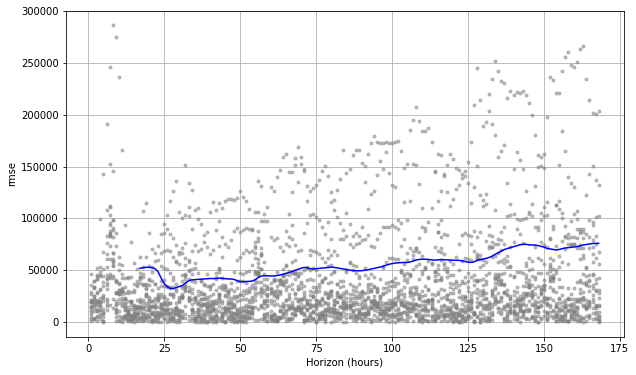

In [143]:
from fbprophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv, 'rmse')

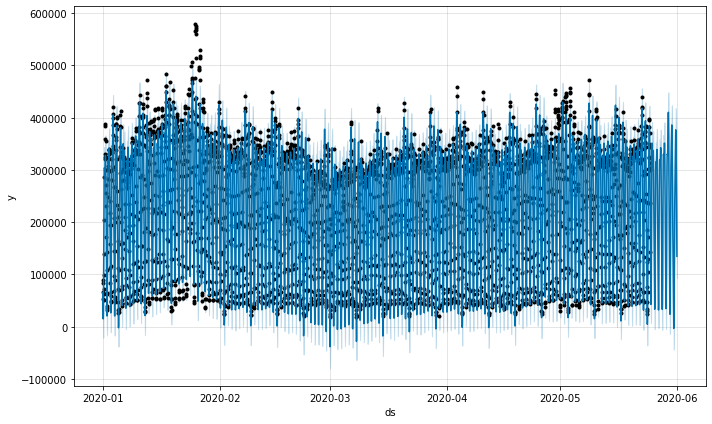

In [138]:
future = m.make_future_dataframe(periods=168, freq='H')
forecast = m.predict(future)
fig = m.plot(forecast)